# 1. Description
Data description sourced from the Kaggle competition page.

### train.csv
- `county` - An ID code for the county.
- `is_business` - Boolean for whether or not the prosumer is a business.
- `product_type` - ID code with the following mapping of codes to contract types: `{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}`.
- `target` - The consumption or production amount for the relevant segment for the hour. The segments are defined by the `county`, `is_business`, and `product_type`.
- `is_consumption` - Boolean for whether or not this row's target is consumption or production.
- `datetime` - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.
- `data_block_id` - All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictins made on October 31st is 100 then the historic weather `data_block_id` for October 31st will be 101 as the historic weather data is only actually available the next day.
- `row_id` - A unique identifier for the row.
- `prediction_unit_id` - A unique identifier for the `county`, `is_business`, and `product_type` combination. *New prediction units can appear or disappear in the test set*.

### gas_prices.csv
- `origin_date` - The date when the day-ahead prices became available.
- `forecast_date` - The date when the forecast prices should be relevant.
- `[lowest/highest]_price_per_mwh` - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
- `data_block_id`

### client.csv
- `product_type`
- `county` - An ID code for the county. See `county_id_to_name_map.json` for the mapping of ID codes to county names.
- `eic_count` - The aggregated number of consumption points (EICs - European Identifier Code).
- `installed_capacity` - Installed photovoltaic solar panel capacity in kilowatts.
- `is_business` - Boolean for whether or not the prosumer is a business.
- `date`
- `data_block_id`

### electricity_prices.csv
- `origin_date`
- `forecast_date` - Represents the start of the 1-hour period when the price is valid.
- `euros_per_mwh` - The price of electricity on the day ahead markets in euros per megawatt hour.
- `data_block_id`

### forecast_weather.csv
Weather forecasts that would have been available at prediction time. Sourced from the [European Centre for Medium-Range Weather Forecasts](https://codes.ecmwf.int/grib/param-db/?filter=grib2).

- `[latitude/longitude]` - The coordinates of the weather forecast.
- `origin_datetime` - The timestamp of when the forecast was generated.
- `hours_ahead` - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- `temperature` - The air temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- `dewpoint` - The dew point temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- `cloudcover_[low/mid/high/total]` - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total. Estimated for the end of the 1-hour period.
- `10_metre_[u/v]_wind_component` - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second. Estimated for the end of the 1-hour period.
- `data_block_id`
- `forecast_datetime` - The timestamp of the predicted weather. Generated from `origin_datetime` plus `hours_ahead`. This represents the start of the 1-hour period for which weather data are forecasted.
- `direct_solar_radiation` - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the hour, in watt-hours per square meter.
- `surface_solar_radiation_downwards` - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, accumulated during the hour, in watt-hours per square meter.
- `snowfall` - Snowfall over hour in units of meters of water equivalent.
- `total_precipitation` - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the described hour, in units of meters.

### historical_weather.csv
[Historic weather data](https://open-meteo.com/en/docs).
- `datetime` - This represents the start of the 1-hour period for which weather data are measured.
- `temperature` - Measured at the end of the 1-hour period.
- `dewpoint` - Measured at the end of the 1-hour period.
- `rain` - Different from the forecast conventions. The rain from large scale weather systems of the hour in millimeters.
- `snowfall` - Different from the forecast conventions. Snowfall over the hour in centimeters.
- `surface_pressure` - The air pressure at surface in hectopascals.
- `cloudcover_[low/mid/high/total]` - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- `windspeed_10m` - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- `winddirection_10m` - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- `shortwave_radiation` - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- `direct_solar_radiation`
- `diffuse_radiation` - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- `[latitude/longitude]` - The coordinates of the weather station.
- `data_block_id`

# 2. Setup

## Import

In [ ]:
import json
from datetime import date, time

import colorcet as cc
import matplotlib.dates as mdates

# import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Image
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from pandas.core.groupby.generic import DataFrameGroupBy
from shapely.geometry import shape

# from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
RAND = 10
RAW_DATA = "../raw_data/"

train_df = pd.read_csv(f"{RAW_DATA}train.csv")
gas_prices_df = pd.read_csv(f"{RAW_DATA}gas_prices.csv")
client_df = pd.read_csv(f"{RAW_DATA}client.csv")
electricity_prices_df = pd.read_csv(f"{RAW_DATA}electricity_prices.csv")
forecast_weather_df = pd.read_csv(f"{RAW_DATA}forecast_weather.csv")
historical_weather_df = pd.read_csv(f"{RAW_DATA}historical_weather.csv")
station_county_mapping = pd.read_csv(
    f"{RAW_DATA}weather_station_to_county_mapping.csv"
)
county_id_to_name_map = pd.read_json(
    f"{RAW_DATA}county_id_to_name_map.json",
    typ="series",
).str.lower()

# External file with Estonian counties boundaries for visualisation
with open("../additional_data/estonia.geojson", "r", encoding="utf-8") as f:
    estonia_geojson = json.load(f)

In [ ]:
CATEGORICAL_DICT = {
    "county": county_id_to_name_map,
    "is_business": {0: "not_business", 1: "business"},
    "is_consumption": {0: "production", 1: "consumption"},
    "product_type": {
        0: "combined",
        1: "fixed",
        2: "general_service",
        3: "spot",
    },
}

PALETTE = sns.color_palette(
    cc.glasbey[:4]
    + [cc.glasbey[8]]
    + cc.glasbey[5:8]
    + [cc.glasbey[4]]
    + [cc.glasbey[12]]
    + cc.glasbey[10:12]
    + [cc.glasbey[9]]
    + cc.glasbey[13:16]
).as_hex()

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]

## Display Options

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', None)

In [ ]:
sns.set_style("whitegrid")

## Functions

In [ ]:
def print_right_filled_header(text: str) -> None:
    """
    Prints the provided header text followed by ">" characters, filling
    the line up to 100 characters.
    """
    total_length = 100
    text = text.strip()
    print("\n" + text + " " + ">" * (total_length - len(text)))

In [ ]:
def total_size(df: pd.DataFrame) -> np.int64:
    "Return total size of the dataframe in megabytes."
    return df.memory_usage().sum() // (1024**2)

In [ ]:
def columns_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize a dataframe with combined information from df.info() and
    df.describe(). Additionally, calculate the maximum length of the
    decimal part for numpy.float64 and numpy.float32 columns.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe to summarize.

    Returns
    -------
    pd.DataFrame
        A combined summary dataframe.
    """

    column_info = {
        "column": df.columns,
        "not_na_count": [],
        "dtype": df.dtypes.values,
        "size_mb": (df.memory_usage().div(1024**2).round(2))[1:],
        "max_dec_len": [],
    }

    for column in df.columns:
        col_data = df[column]
        column_info["not_na_count"].append(col_data.notna().sum())

        if (not isinstance(col_data.dtype, pd.CategoricalDtype)) and (
            np.issubdtype(col_data.dtype, np.float64)
            or np.issubdtype(col_data.dtype, np.float32)
        ):
            decimal_len = (
                col_data.dropna()
                .apply(lambda x: len(str(x).split(".")[1]))
                .max()
            )
            column_info["max_dec_len"].append(decimal_len)
        else:
            column_info["max_dec_len"].append(-1)

    df = pd.merge(
        pd.DataFrame(
            data=column_info,
        ),
        df.describe(include="all").drop("count").T.reset_index(names="column"),
        on=["column"],
    )

    first_columns = [
        "column",
        "dtype",
        "size_mb",
        "max_dec_len",
        "min",
        "max",
    ]
    other_columns = [
        column for column in df.columns if column not in first_columns
    ]

    return df.loc[:, first_columns + other_columns]

In [ ]:
def df_show_info(df: pd.DataFrame) -> None:
    """
    Print the number of dataframe NaNs, the count of duplicated rows
    and display a summary of the dataframe.
    """

    print_right_filled_header("HEAD")
    display(df.head())

    print_right_filled_header("TAIL")
    display(df.tail())

    print_right_filled_header("MISSING VALUES")
    nan_counts = df.isna().sum()
    nan_series = nan_counts[nan_counts > 0]
    if nan_series.empty:
        print("No missing values.")
    else:
        display(nan_series)

    print_right_filled_header("FULL DUPLICATES")
    dup_counts = df.duplicated().sum()
    if dup_counts:
        display(f"Total duplicated rows: {dup_counts}")
    else:
        print("No duplicate rows.")

    print_right_filled_header("TOTAL SIZE")
    print(f"Total DataFrame size: {total_size(df)} MB.")

    print_right_filled_header("SUMMARY")
    display(columns_summary(df))

In [ ]:
def categorical_mapper(
    df: pd.DataFrame,
    values_mapper: dict,
) -> pd.DataFrame:
    """
    Map categorical columns in the dataframe to their corresponding
    values based on the provided mapper and convert these columns to
    categorical type.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to process.
    values_mapper : dict
        A dictionary where keys are column names, and values are
        mapping dictionaries.

    Returns
    -------
    pd.DataFrame
        Modified dataframe with specified columns mapped to their
        categorical values.
    """
    for key, value in values_mapper.items():
        if key in df.columns:
            df[key] = df[key].map(value).astype("category")
        else:
            print(
                "categorical_mapper:",
                f"column '{key}' not found in dataframe, skipping."
            )

    return df

In [ ]:
def mismatched_indices_check(
    date_diff: pd.Series,
    id_diff: pd.Series,
    difference: np.float64,
) -> None:
    """
    Check if rows with an n-day difference in the date_diff have
    mismatched indices with id_diff rows that have a difference of n
    and print it.
    """

    print(
        f"Difference {difference}: ",[
            "no mismatches",
            "indices mismatch detected"][
        int(np.any(
            date_diff[date_diff == pd.Timedelta(difference, "day")]
            .index
            != id_diff[id_diff == difference].index))],
        ".",
        sep="",
    )

In [ ]:
def same_groups(dfgb: DataFrameGroupBy, column: str) -> pd.Series:
    """
    Combine values of the specified column in each subgroup into
    tuples, compare these tuples within each group, and return a
    pd.Series of boolean values indicating whether each tuple is a duplicate.
    """
    return dfgb[column].agg(tuple).duplicated()

In [ ]:
def circle_label(color: tuple | str, label: str) -> Line2D:
    """
    Create a handle for legend with a circular marker with specified
    color and label.
    """
    return Line2D(
        [],
        [],
        color=color,
        marker="o",
        linestyle="None",
        markersize=8,
        label=label,
    )

In [ ]:
def unique_combinations(df: pd.DataFrame, combination: list) -> pd.DataFrame:
    return (
        df[combination]
        .drop_duplicates()
        .sort_values(combination, ignore_index=True)
    )

# 3. Data Preparation

## Feature Commentary

From description:
- `datetime` - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- `data_block_id` - All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictins made on October 31st is 100 then the historic weather `data_block_id` for October 31st will be 101 as the historic weather data is only actually available the next day.
- `row_id` - A unique identifier for the row.
- `prediction_unit_id` - A unique identifier for the `county`, `is_business`, and `product_type` combination. *New prediction units can appear or disappear in the test set*.
***
Also, the competition host <u>[provided](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/discussion/455833)</u> this scheme along with comments:

Let’s say we are on day D at 11am. We want to predict next day D+1 net consumption from 00 to 23 for every hours.
<table style="border: 1px solid black; border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Category</th>
    <th style="border: 1px solid black;">Weather forecast</th>
    <th style="border: 1px solid black;">Historical weather</th>
    <th style="border: 1px solid black;">Historical consumption and production / Client data</th>
    <th style="border: 1px solid black;">Electricity prices</th>
    <th style="border: 1px solid black;">Gas prices</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Last available data</td>
    <td style="border: 1px solid black;">Forecast for every hours of D and D+1 (published on D)</td>
    <td style="border: 1px solid black;">Every hours until day D, 10 am</td>
    <td style="border: 1px solid black;">Every hours of Day D-1</td>
    <td style="border: 1px solid black;">Every hours of day D (published on D-1)</td>
    <td style="border: 1px solid black;">Data for day D (published on D-1)</td>
  </tr>
</table>

Prices are published everyday at 2 pm (so after 11 am), that is we do not have D+1 prices.
The data_block_id already reflects this timeline of availability of the data. There is no need to apply additional lag if joining on data_block_id.
***
Electricity and gas prices, dates, and `data_block_id` were additionally <u>[clarified](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/discussion/456636#2533090)</u>:

> Q: Are the values in the gas & electricity data actual values or predicted?

> A: Actual values. Prices are published everyday for the next day. However we predict electricity consumption and production earlier, so next day's prices are not yet available when predicting next day's production and consumption
***
Later, I will explore whether there are any discrepancies in the correlations between `data_block_id` and `datetime`, or between `prediction_unit_id` and the `categorical features`. For now, I will analyze the data by:
1. Checking all dataframes using `describe()` and `info()`.
2. Verifying the presence of missing values or duplicates.

## train_df

In [ ]:
df_show_info(train_df)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.71,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.59,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.00,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.31,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.90,0,2021-09-01 00:00:00,0,4,2



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
2018347,15,1,0,197.23,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.00,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.40,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.00,0,2023-05-31 23:00:00,637,2018350,60
2018351,15,1,3,196.24,1,2023-05-31 23:00:00,637,2018351,60



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


target    528
dtype: int64


FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 138 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,county,int64,15.40,-1,0.00,15.00,2018352,NaN,NaN,NaN,7.30,4.78,3.00,7.00,11.00
1,is_business,int64,15.40,-1,0.00,1.00,2018352,NaN,NaN,NaN,0.54,0.50,0.00,1.00,1.00
2,product_type,int64,15.40,-1,0.00,3.00,2018352,NaN,NaN,NaN,1.90,1.08,1.00,2.00,3.00
3,target,float64,15.40,3,0.00,15480.27,2017824,NaN,NaN,NaN,274.86,909.50,0.38,31.13,180.21
4,is_consumption,int64,15.40,-1,0.00,1.00,2018352,NaN,NaN,NaN,0.50,0.50,0.00,0.50,1.00
5,datetime,object,15.40,-1,NaN,NaN,2018352,15312,2022-11-27 12:00:00,138,NaN,NaN,NaN,NaN,NaN
6,data_block_id,int64,15.40,-1,0.00,637.00,2018352,NaN,NaN,NaN,321.87,182.63,166.00,323.00,479.00
7,row_id,int64,15.40,-1,0.00,2018351.00,2018352,NaN,NaN,NaN,1009175.50,582648.18,504587.75,1009175.50,1513763.25
8,prediction_unit_id,int64,15.40,-1,0.00,68.00,2018352,NaN,NaN,NaN,33.05,19.59,16.00,33.00,50.00


- There are a few missing values (528/2,018,352 < 0.1%) and no duplicates in the dataframe. Only the `target` feature has missing values.
- The categorical features `county`, `is_business`, `product_type`, and `is_consumption` can be converted to the categorical data type. Their values can be renamed to improve clarity and understanding.
- The `target` feature can be converted to `float32` because its values range from 0.0 to 15,480.27, and the standard deviation (910.20) is relatively large compared to the mean (274.86), indicating a wide distribution of values. Given the dataset size (2,017,824 records), the precision of the fractional part becomes less significant, and `float32` provides adequate precision while reducing memory usage.
- The `datetime` feature can be converted to `datetime64[ns]` for proper handling of data.
- The `data_block_id` feature can be converted to `uint16` (range: 0 through 65,535) as its maximum value is small.
- The `row_id` feature is similar to the index values in the current default sorting. For now, it can be converted to `uint32` (range: 0 through 4,294,967,295) as its range fits well within this data type, and the use of `int64` is unnecessary because it supports negative numbers, which are irrelevant in this case.
- The `prediction_unit_id` feature can be converted to `uint8` (range: 0 through 255). Although new combinations may appear in the future, this data type is sufficient to uniquely represent all future combinations of current county, is_business, and product_type (16 * 2 * 4 = 96).

### Data Transformation

In [ ]:
# Reorder columns
train_df = train_df[
    [
        "county",
        "product_type",
        "is_business",
        "is_consumption",
        "datetime",
        "target",
        "data_block_id",
        "row_id",
        "prediction_unit_id",
    ]
]

# Rename categorical values to avoid confusion and improve readability
train_df = categorical_mapper(train_df, CATEGORICAL_DICT)

# Change data types to reduce memory usage
train_df = train_df.astype(
    {
        "target": "float32",
        "data_block_id": "uint16",
        "row_id": "uint32",
        "prediction_unit_id": "uint8",
        "datetime": "datetime64[ns]",
    }
)

print(f"Size after transformation: {total_size(train_df)} MB.")

Size after transformation: 44 MB.


### Partial Duplicates

In [ ]:
# Check timestamp and categorical features for duplicates
train_df.duplicated(TARGET_C).sum()

0

No partial duplicates.

### Missing Values

In [ ]:
# Display rows with missing values from the dataframe
train_df[train_df.isna().any(axis=1)].head()

,county,product_type,is_business,is_consumption,datetime,target,data_block_id,row_id,prediction_unit_id
178938,harjumaa,fixed,not_business,production,2021-10-31 03:00:00,NaN,60,178938,0
178939,harjumaa,fixed,not_business,consumption,2021-10-31 03:00:00,NaN,60,178939,0
178940,harjumaa,general_service,not_business,production,2021-10-31 03:00:00,NaN,60,178940,1
178941,harjumaa,general_service,not_business,consumption,2021-10-31 03:00:00,NaN,60,178941,1
178942,harjumaa,spot,not_business,production,2021-10-31 03:00:00,NaN,60,178942,2


The `datetime` values for rows with missing target values start from '2021-10-31 03:00:00', rather than from '2021-09-01 00:00:00'.

In [ ]:
# Create array with timestamps corresponding to rows with missing
# target values
na_datetimes = train_df[train_df.isna().any(axis=1)].datetime.unique()
na_datetimes

<DatetimeArray>
['2021-10-31 03:00:00', '2022-03-27 03:00:00', '2022-10-30 03:00:00',
 '2023-03-26 03:00:00']
Length: 4, dtype: datetime64[ns]

All missing values correspond to the start or end of daylight saving time.

In [ ]:
# Check that all values for these timestamps are missing
train_df.isna().values.sum() == (
    train_df.loc[
        train_df["datetime"].isin(na_datetimes), ["target"]
    ].shape[0]
)

True

- All target values at these timestamps are missing.
- Estonia uses daylight saving time (EET / EEST alternately), and it might be worth adding a flag to track the current DST state.

Since the number of `NaN` values is small and these hours correspond to the switch to or from DST, it is acceptable to drop them.

In [ ]:
train_df = train_df.dropna()

### Consistency and Relationship

#### Row Identifier

In [ ]:
# Check if row_id values are equal to index values
(train_df["row_id"] != train_df.index).sum()

0

All `row_id` values are equal to index values.

#### Datetime and data_block_id

For predictions made for day D + 1, all historical consumption and production data should have `data_block_id` values equal to D - 1. This is because the `data_block_id` represents the data available at a specific time. Data for day D is unavailable at the time of prediction, as it corresponds to the current day, and no historical data exists for it yet.

To validate this, the `datetime` and `data_block_id` columns require a check to ensure that, in chronological order, both date and ID values progress uniformly. If a single date corresponds to multiple `data_block_id` values, it will be evident because the differences between consecutive rows in these two columns will not be consistent.

In [ ]:
# Create variables to store the differences between the current and
# previous row for all rows in datetime and data_block_id
train_date_diff = train_df["datetime"].dt.date.diff()
train_id_diff = train_df["data_block_id"].diff()

# Print unique values to verify that default order reflects sorting
# from oldest to newest without skips
print(train_date_diff.value_counts(dropna=False))
print(train_id_diff.value_counts(dropna=False))

datetime
0 days    2017186
1 days        637
NaT             1
Name: count, dtype: int64
data_block_id
0.00    2017186
1.00        637
NaN           1
Name: count, dtype: int64


- `NaT` and `NaN` values correspond to the first row in both columns, where no previous row data is available for comparison.
- A value of '0' indicates that the current and previous rows belong to the same day.
- A value of '1' indicates the transition from one day to the next.

In [ ]:
for difference in train_id_diff.unique():
    mismatched_indices_check(train_date_diff, train_id_diff, difference)

Difference nan: no mismatches.
Difference 0.0: no mismatches.
Difference 1.0: no mismatches.


The default order of the raw data for this dataframe is sorted by datetime, and the `data_block_id` reflects the actual data availability, with no errors observed in the `datetime` column.

#### Time Series Gaps

In [ ]:
df_for_missing = train_df[TARGET_C + ["target"]].copy()

# Add hour index starting from the beginning
df_for_missing["hour_index"] = (
    (df_for_missing["datetime"] - df_for_missing["datetime"].min())
    // pd.Timedelta(hours=1)
).astype(np.uint16)

# Add a group index corresponding to the unique combination of all
# categorical features (i.e. this feature is not equal to
# prediction_unit_id): county, is_business, product_type,
# is_consumption.
# The maximum number of combinations is 16 * 4 * 2 * 2 = 256, but the
# actual number of observed values is less than 256
df_for_missing["group_index"] = (
    df_for_missing.groupby(CATEGORICAL_C, observed=True,)
    .ngroup()
    .astype(np.uint8)
)

# Create a 2D array with a shape equal to the number of groups and the
# total number of hours between the minimum and maximum timestamps
n_groups = df_for_missing["group_index"].nunique()
n_hours = df_for_missing["hour_index"].max() + 1
missmap = np.full((n_groups, n_hours), np.nan)

# Fill the array with the corresponding flag values
missmap[df_for_missing["group_index"], df_for_missing["hour_index"]] = (
    df_for_missing["target"] != 0
)

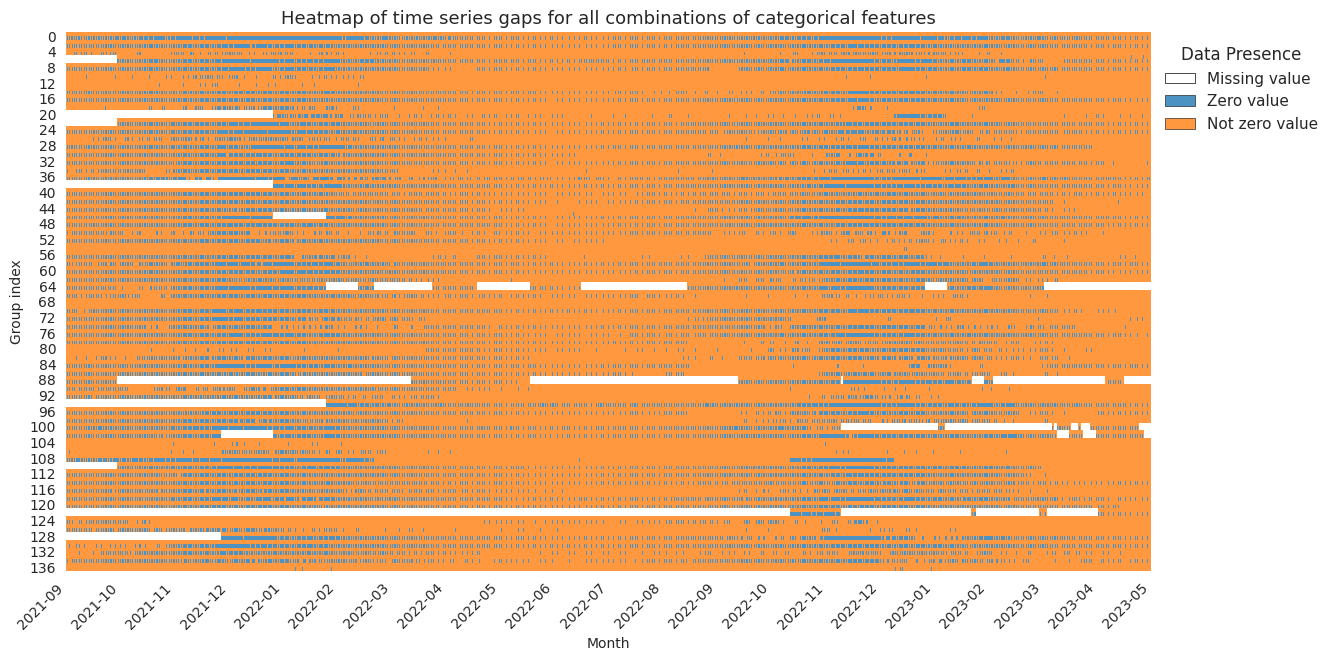

In [ ]:
alpha = 0.8

min_date = df_for_missing["datetime"].min()
max_date = df_for_missing["datetime"].max()
n_months = len(pd.date_range(start=min_date, end=max_date, freq="ME"))

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(
    missmap,
    cmap=sns.color_palette(["tab:blue", "tab:orange"]),
    cbar=False,
    alpha=alpha,
    ax=ax,
)

xtick_indices = np.linspace(0, n_hours, num=n_months, dtype=int)
xtick_labels = pd.date_range(min_date, max_date, freq="MS")

ax.set_xticks(xtick_indices)
ax.set_xticklabels(
    xtick_labels.strftime("%Y-%m"),
    rotation=45,
    ha="right",
)

dx, dy = 0, -2.5
for label in ax.get_yticklabels():
    offset = mt.ScaledTranslation(dx / 72, dy / 72, fig.dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)

legend_patches = [
    mpatches.Patch(
        facecolor="white",
        label="Missing value",
        edgecolor="black",
        linewidth=0.5,
    ),
    mpatches.Patch(
        facecolor="tab:blue",
        alpha=alpha,
        label="Zero value",
        edgecolor="black",
        linewidth=0.5,
    ),
    mpatches.Patch(
        facecolor="tab:orange",
        alpha=alpha,
        label="Not zero value",
        edgecolor="black",
        linewidth=0.5,
    ),
]

plt.legend(
    handles=legend_patches,
    title="Data Presence",
    title_fontsize=12,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    fontsize=11,
    frameon=False,
)

plt.title(
    "Heatmap of time series gaps for all combinations "
    "of categorical features",
    fontsize=13,
)
plt.xlabel("Month", fontsize=10)
plt.ylabel("Group index", fontsize=10)
plt.grid(False)
plt.show()

The plot shows that time series across different groups have varying start and end dates. Some groups have large gaps in their values, missing data is unevenly distributed, and the overall data volume varies between groups. It is worth noting that more zero values are observed in winter than in summer. Additionally, these zero values appear every other row, which suggests that the data reflects electricity production. Missing values corresponding to the switch to or from DST ([1 hour](#Missing-Values)) are not displayed because the plot is too dense to distinguish individual values.

#### Categorical Features Ratio

In [ ]:
# Check that each combination of county, product_type, and
# is_business corresponds to exactly one unique prediction_unit_id
(
    train_df.groupby(
        SEGMENT_C,
        observed=True,
    )["prediction_unit_id"].nunique()
    != 1
).sum()

0

All combinations of `county`, `is_business`, and `product_type` correspond to a single `prediction_unit_id`, with no errors.

In [ ]:
for c in CATEGORICAL_C:
    print(train_df[c].value_counts())
    print()

county
harjumaa         212872
tartumaa         197948
pärnumaa         173042
lääne-virumaa    151592
võrumaa          148714
jõgevamaa        147226
saaremaa         134604
viljandimaa      125776
järvamaa         122464
raplamaa         122464
valgamaa         121024
ida-virumaa      115170
hiiumaa           91848
põlvamaa          91848
läänemaa          30616
unknown           30616
Name: count, dtype: int64

product_type
spot               918480
fixed              781428
combined           170500
general_service    147416
Name: count, dtype: int64

is_business
business        1083222
not_business     934602
Name: count, dtype: int64

is_consumption
consumption    1008912
production     1008912
Name: count, dtype: int64



Classes in each category except `is_consumption` are imbalanced.

In [ ]:
# Check that in each segment the number of production and consumptuon
# values are the same
train_df.groupby(CATEGORICAL_C, as_index=False, observed=True)[
    "target"
].count().groupby(SEGMENT_C, as_index=False, observed=True)[
    "target"
].nunique()[
    "target"
].nunique()

1

Yes, in each segment (combination of `county`, `product_type`, `is_business`) the count of `target` entries is identical for `production` and `consumption`.

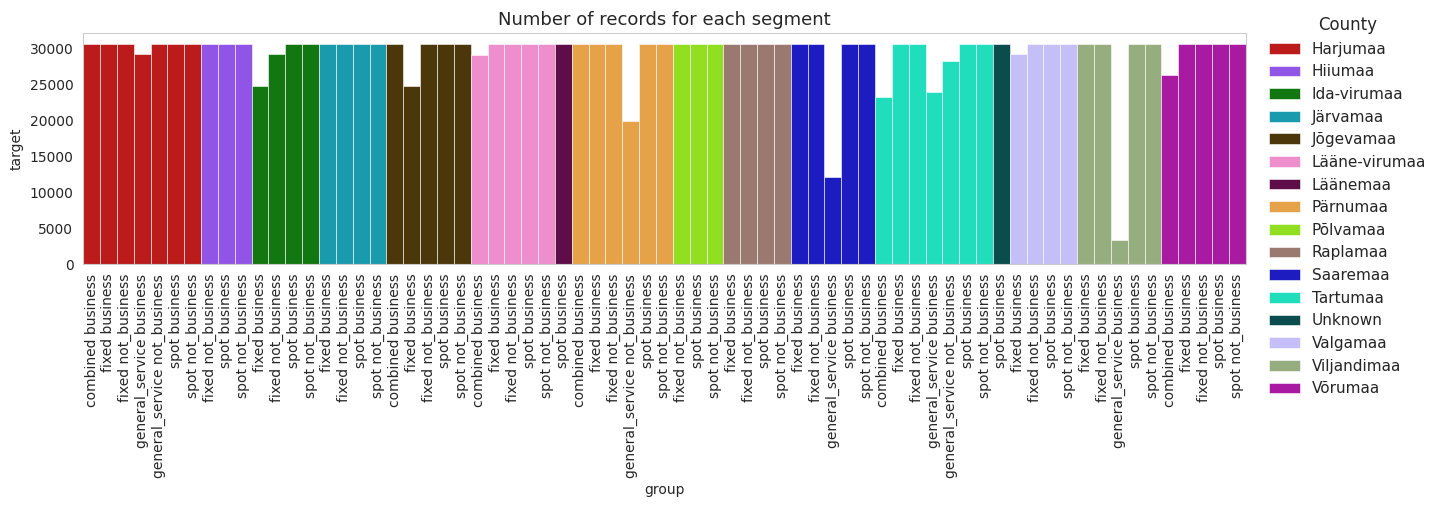

In [ ]:
# Plot the visualisation of the number of entries for each unique
# combination of categorical features

# Create a DF with all segments and their counts of target values
train_categories = train_df.groupby(
    SEGMENT_C,
    as_index=False,
    observed=True,
)["target"].count()

# Create columns with concatenated labels for segments
train_categories["group"] = (
    train_categories[SEGMENT_C].astype(str).agg(" ".join, axis=1)
)

fig, ax = plt.subplots(figsize=(15, 3))
sns.barplot(
    data=train_categories,
    x="group",
    y="target",
    hue="county",
    palette=PALETTE,
    width=1,
    linewidth=0.4,
)

handles, labels = ax.get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
plt.legend(
    handles=handles,
    labels=labels,
    title="County",
    title_fontsize=12,
    bbox_to_anchor=(1.015, 1.1),
    loc="upper left",
    borderaxespad=0,
    markerscale=3,
    frameon=False,
    fontsize=11,
)

plt.title("Number of records for each segment", fontsize=13)
plt.grid(False)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(
    train_categories["group"].str.split(n=1).str[1],
    rotation=90,
    fontsize=10,
)
plt.show()

The number of entries in each segment ranges from around 4,000 to 30,000, and the number of subgroups also varies across counties.

## gas_prices_df

In [ ]:
df_show_info(gas_prices_df)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636
636,2023-05-30,29.00,34.00,2023-05-29,637



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No missing values.

FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 0 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,forecast_date,object,0.00,-1,NaN,NaN,637,637,2021-09-01,1,NaN,NaN,NaN,NaN,NaN
1,lowest_price_per_mwh,float64,0.00,2,28.10,250.00,637,NaN,NaN,NaN,95.04,47.55,60.00,85.21,109.00
2,highest_price_per_mwh,float64,0.00,2,34.00,305.00,637,NaN,NaN,NaN,107.75,54.74,67.53,93.47,130.74
3,origin_date,object,0.00,-1,NaN,NaN,637,637,2021-08-31,1,NaN,NaN,NaN,NaN,NaN
4,data_block_id,int64,0.00,-1,1.00,637.00,637,NaN,NaN,NaN,319.00,184.03,160.00,319.00,478.00


- There are no missing values or duplicates in the dataframe.
- The `data_block_id` values start from 1, unlike the `data_block_id` values in train_df, which start from 0. This difference exists because </u>[`[lowest/highest]_price_per_mwh` are end-of-day prices and aren't available in the late morning when forecasts are made](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/discussion/453355#2515054)</u>.

### Data Transformation

In [ ]:
# Reorder columns
gas_prices_df = gas_prices_df[
    [
        "origin_date",
        "forecast_date",
        "data_block_id",
        "lowest_price_per_mwh",
        "highest_price_per_mwh",
    ]
]

# Change data types to reduce memory usage
gas_prices_df = gas_prices_df.astype(
    {
        "origin_date": "datetime64[ns]",
        "forecast_date": "datetime64[ns]",
        "data_block_id": "uint16",
        "lowest_price_per_mwh": "float32",
        "highest_price_per_mwh": "float32",
    }
)

### Partial Duplicates

In [ ]:
# Check timestamps for duplicates
gas_prices_df.duplicated(["forecast_date", "origin_date"]).sum()

0

No partial duplicates.

### Consistency and Relationship Validation
#### Origin and forecast dates
Due to the strong correlation between the two datetime columns (at least based on the description and a few observed rows), it's necessary to verify if this correlation holds true.

In [ ]:
# Check that each origin date is the next day compared to the previous
# one
gas_date_diff = gas_prices_df["origin_date"].diff()
print(gas_date_diff.value_counts(dropna=False))

origin_date
1 days    636
NaT         1
Name: count, dtype: int64


- Yes, all values are chronological days without skips. The `NaT` value corresponds to the first date, where no previous date exists for comparison.

In [ ]:
# Check if any forecast dates are not exactly one day after origin dates
(
    gas_prices_df["origin_date"] + pd.Timedelta(days=1)
    != gas_prices_df["forecast_date"]
).sum()

0

- All `origin_date` values are correct and represent the day before their corresponding `forecast_date` values. This means that correlation between these features is 1, and one of them can likely be deleted.
- The raw data in this dataframe is sorted chronologically by datetime.

#### Origin date and data_block_id

In [ ]:
gas_id_diff = gas_prices_df["data_block_id"].diff()
print(gas_id_diff.value_counts(dropna=False))

data_block_id
1.00    636
NaN       1
Name: count, dtype: int64


In [ ]:
for difference in gas_id_diff.unique():
    mismatched_indices_check(gas_date_diff, gas_id_diff, difference)

Difference nan: no mismatches.
Difference 1.0: no mismatches.


- Similar to `origin_date`, the first value is missing, and all subsequent values have a difference of 1. Since the differences are consistent across both columns, it can be concluded that there are no errors between `origin_date` and `data_block_id`.

## client_df

In [ ]:
df_show_info(client_df)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637
41918,3,15,55,2188.20,1,2023-05-29,637



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No missing values.

FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 2 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,product_type,int64,0.32,-1,0.00,3.00,41919,NaN,NaN,NaN,1.90,1.08,1.00,2.00,3.00
1,county,int64,0.32,-1,0.00,15.00,41919,NaN,NaN,NaN,7.30,4.78,3.00,7.00,11.00
2,eic_count,int64,0.32,-1,5.00,1517.00,41919,NaN,NaN,NaN,73.35,144.06,13.00,32.00,70.00
3,installed_capacity,float64,0.32,15,5.50,19314.31,41919,NaN,NaN,NaN,1450.77,2422.23,321.90,645.20,1567.15
4,is_business,int64,0.32,-1,0.00,1.00,41919,NaN,NaN,NaN,0.54,0.50,0.00,1.00,1.00
5,date,object,0.32,-1,NaN,NaN,41919,636,2022-11-26,69,NaN,NaN,NaN,NaN,NaN
6,data_block_id,int64,0.32,-1,2.00,637.00,41919,NaN,NaN,NaN,322.90,182.08,167.00,324.00,480.00


- There are no missing values or duplicates in the dataframe.
- The `data_block_id` values start from 2 instead of 0 or 1, as mentioned earlier.

### Data Transformation

In [ ]:
# Reorder columns
client_df = client_df[
    [
        "county",
        "product_type",
        "is_business",
        "date",
        "eic_count",
        "installed_capacity",
        "data_block_id",
    ]
]

# Rename categorical values to avoid confusion and improve readability
client_df = categorical_mapper(client_df, CATEGORICAL_DICT)

# Change data types to reduce memory usage
client_df = client_df.astype(
    {
        "date": "datetime64[ns]",
        "eic_count": "uint32",
        "installed_capacity": "float32",
        "data_block_id": "uint16",
    }
)

categorical_mapper: column 'is_consumption' not found in dataframe, skipping.


### Partial duplicates

In [ ]:
# Check timestamp and categorical features for duplicates
client_df.duplicated(["county", "product_type", "is_business", "date"]).sum()

0

No partial duplicates.

### Consistency and Relationship Validation
#### Date and data_block_id
As with the previous dataframes, it is necessary to validate the correlation between `date` and `data_block_id`.

In [ ]:
# Create variables to store the differences between the current and
# previous row for all rows in date and data_block_id
client_date_diff = client_df["date"].dt.date.diff()
client_id_diff = client_df["data_block_id"].diff()


# Print unique values to verify that default order reflects sorting
# from oldest to newest without skips
print(client_date_diff.value_counts(dropna=False))
print(client_id_diff.value_counts(dropna=False))

date
0 days    41283
1 days      635
NaT           1
Name: count, dtype: int64
data_block_id
0.00    41283
1.00      635
NaN         1
Name: count, dtype: int64


- `NaT` and `NaN` values correspond to the first row in both columns, where no previous row data is available for comparison.
- A value of '0' indicates that the current and previous rows belong to the same day.
- A value of '1' indicates the transition from one day to the next.

In [ ]:
for difference in client_id_diff.unique():
    mismatched_indices_check(client_date_diff, client_id_diff, difference)

Difference nan: no mismatches.
Difference 0.0: no mismatches.
Difference 1.0: no mismatches.


- The default order of the raw data for this dataframe is sorted by datetime, and the `data_block_id` reflects the actual data availability, with no errors observed in the `date` column.

## electricity_prices_df

In [ ]:
df_show_info(electricity_prices_df)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,forecast_date,euros_per_mwh,origin_date,data_block_id
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637
15285,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,637



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No missing values.

FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 0 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,forecast_date,object,0.12,-1,NaN,NaN,15286,15286,2021-09-01 00:00:00,1,NaN,NaN,NaN,NaN,NaN
1,euros_per_mwh,float64,0.12,2,-10.06,4000.00,15286,NaN,NaN,NaN,157.06,121.15,85.29,128.28,199.80
2,origin_date,object,0.12,-1,NaN,NaN,15286,15286,2021-08-31 00:00:00,1,NaN,NaN,NaN,NaN,NaN
3,data_block_id,int64,0.12,-1,1.00,637.00,15286,NaN,NaN,NaN,318.99,183.89,160.00,319.00,478.00


- There are no missing values or duplicates in the dataframe.
- The `data_block_id` values start from 1.
- The minimum value of the `euros_per_mwh` column is negative.

### Data Transformation

In [ ]:
# Change data types to reduce memory usage
electricity_prices_df = electricity_prices_df.astype(
    {
        "origin_date": "datetime64[ns]",
        "forecast_date": "datetime64[ns]",
        "euros_per_mwh": "float32",
        "data_block_id": "uint16",
    }
)

# Datetime at which the forecast will be available for the model
electricity_prices_df["electricity_datetime"] = electricity_prices_df[
    "origin_date"
] + pd.Timedelta(2, "d")

# Reorder columns
electricity_prices_df = electricity_prices_df[
    [
        "electricity_datetime",
        "euros_per_mwh",
        "data_block_id",
        "origin_date",
        "forecast_date",
    ]
]

# Rename to reflect hourly timestamps instead of just dates
electricity_prices_df = electricity_prices_df.rename(
    columns={
        "origin_date": "origin_datetime",
        "forecast_date": "forecast_datetime",
    }
)

### Partial Duplicates

In [ ]:
# Check timestamps for duplicates
electricity_prices_df.duplicated(["origin_datetime", "forecast_datetime"]).sum()

0

No partial duplicates.

### Non-positive Prices

In [ ]:
electricity_prices_df[electricity_prices_df["euros_per_mwh"] <= 0].shape

(36, 5)

According to the [<u>official comment</u>](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/discussion/454932#2523730), such prices are not an error.

[<u>Negative pricing</u>](https://en.wikipedia.org/wiki/Negative_pricing) can occur when demand for a product drops or supply increases to an extent that owners or suppliers are prepared to pay others to accept it, in effect setting the price to a negative number.

### Consistency and Relationship Validation
As with `gas_prices_df`, it is necessary to validate the correlation between `origin_datetime`, `forecast_datetime`, and `data_block_id`.
#### Origin and forecast dates

In [ ]:
# Check that each electricity_origin_date is the next hour compared
# to the previous one
print(
    electricity_prices_df["origin_datetime"]
    .diff()
    .value_counts(dropna=False)
)

origin_datetime
0 days 01:00:00    15283
0 days 02:00:00        2
NaT                    1
Name: count, dtype: int64


There are also values with a 2-hour difference. This might indicate an issue with data collection or other inconsistencies.

In [ ]:
electricity_prices_df[
    electricity_prices_df["origin_datetime"].diff()
    == pd.Timedelta(2, "hour")
]

,electricity_datetime,euros_per_mwh,data_block_id,origin_datetime,forecast_datetime
4970,2022-03-28 03:00:00,100.07,208,2022-03-26 03:00:00,2022-03-27 03:00:00
13705,2023-03-27 03:00:00,40.12,572,2023-03-25 03:00:00,2023-03-26 03:00:00


A 2-hour time difference occurs at 03:00 on `2022-03-27` and `2023-03-26` due to the transition to daylight saving time. This transition results in an increased time difference between records.

In [ ]:
# Check if any forecast dates are not exactly one day after origin dates
(
    electricity_prices_df["origin_datetime"]
    + pd.Timedelta(days=1)
    != electricity_prices_df["forecast_datetime"]
).sum()

0

- All `origin_datetime` values represent the day before their corresponding `forecast_datetime` values.
- The raw data in this dataframe is sorted chronologically by datetime.

#### Origin date and data_block_id

In [ ]:
# Create variables to store the differences between the current and
# previous row for all rows in origin_datetime and data_block_id
electricity_date_diff = electricity_prices_df[
    "origin_datetime"
].dt.date.diff()
electricity_id_diff = electricity_prices_df["data_block_id"].diff()

# Print unique values to verify that default order reflects sorting
# from oldest to newest without skips
print(electricity_date_diff.value_counts(dropna=False))
print(electricity_id_diff.value_counts(dropna=False))

origin_datetime
0 days    14649
1 days      636
NaT           1
Name: count, dtype: int64
data_block_id
0.00    14649
1.00      636
NaN         1
Name: count, dtype: int64


- `NaT` and `NaN` values correspond to the first row in both columns, where no previous row data is available for comparison.
- A value of '0' indicates that the current and previous rows belong to the same day.
- A value of '1' indicates the transition from one day to the next.

In [ ]:
for difference in electricity_id_diff.unique():
    mismatched_indices_check(
        electricity_date_diff, electricity_id_diff, difference
    )

Difference nan: no mismatches.
Difference 0.0: no mismatches.
Difference 1.0: no mismatches.


- The default order of the raw data for this dataframe is sorted by datetime, and the `data_block_id` reflects the actual data availability, with no errors observed in the `origin_datetime` column.

## forecast_weather_df

In [ ]:
df_show_info(forecast_weather_df)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.60,21.70,2021-09-01 02:00:00,1,15.66,11.55,0.90,0.02,0.00,0.91,-0.41,-9.11,1,2021-09-01 03:00:00,0.00,0.00,0.00,0.00
1,57.60,22.20,2021-09-01 02:00:00,1,13.00,10.69,0.89,4.46e-03,0.00,0.89,0.21,-5.36,1,2021-09-01 03:00:00,0.00,0.00,0.00,0.00
2,57.60,22.70,2021-09-01 02:00:00,1,14.21,11.67,0.73,5.62e-03,0.00,0.73,1.45,-7.42,1,2021-09-01 03:00:00,0.00,0.00,0.00,0.00
3,57.60,23.20,2021-09-01 02:00:00,1,14.84,12.26,0.34,0.07,6.26e-04,0.39,1.09,-9.16,1,2021-09-01 03:00:00,0.00,0.00,0.00,0.00
4,57.60,23.70,2021-09-01 02:00:00,1,15.29,12.46,0.10,0.09,1.53e-05,0.18,1.27,-8.98,1,2021-09-01 03:00:00,0.00,0.00,0.00,0.00



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
3424507,59.70,26.20,2023-05-30 02:00:00,48,10.15,5.66,0.06,0.26,4.06e-03,0.31,6.89,-3.26,637,2023-06-01 02:00:00,0.00,0.00,0.00,0.00
3424508,59.70,26.70,2023-05-30 02:00:00,48,10.26,5.92,0.11,0.90,0.20,0.91,6.89,-3.77,637,2023-06-01 02:00:00,0.00,0.00,0.00,0.00
3424509,59.70,27.20,2023-05-30 02:00:00,48,10.47,6.07,0.00,0.39,0.45,0.53,6.21,-4.70,637,2023-06-01 02:00:00,0.00,0.00,0.00,0.00
3424510,59.70,27.70,2023-05-30 02:00:00,48,10.69,7.01,0.00,0.51,1.00,1.00,5.81,-4.34,637,2023-06-01 02:00:00,0.00,0.00,0.00,0.00
3424511,59.70,28.20,2023-05-30 02:00:00,48,11.23,7.07,0.70,0.29,0.93,0.99,2.72,-0.92,637,2023-06-01 02:00:00,0.00,0.00,0.00,0.00



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


surface_solar_radiation_downwards    2
dtype: int64


FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 470 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,latitude,float64,26.13,1,57.60,59.70,3424512,NaN,NaN,NaN,58.65,0.69,58.12,58.65,59.17
1,longitude,float64,26.13,1,21.70,28.20,3424512,NaN,NaN,NaN,24.95,2.02,23.20,24.95,26.70
2,origin_datetime,object,26.13,-1,NaN,NaN,3424512,637,2021-09-01 02:00:00,5376,NaN,NaN,NaN,NaN,NaN
3,hours_ahead,int64,26.13,-1,1.00,48.00,3424512,NaN,NaN,NaN,24.50,13.85,12.75,24.50,36.25
4,temperature,float64,26.13,20,-27.50,31.81,3424512,NaN,NaN,NaN,5.74,7.84,0.26,4.87,11.15
5,dewpoint,float64,26.13,20,-29.68,23.68,3424512,NaN,NaN,NaN,2.41,7.12,-2.36,1.84,7.30
6,cloudcover_high,float64,26.13,20,0.00,1.00,3424512,NaN,NaN,NaN,0.39,0.44,0.00,0.09,0.98
7,cloudcover_low,float64,26.13,20,0.00,1.00,3424512,NaN,NaN,NaN,0.43,0.44,3.36e-04,0.23,1.00
8,cloudcover_mid,float64,26.13,20,0.00,1.00,3424512,NaN,NaN,NaN,0.36,0.42,0.00,0.10,0.90
9,cloudcover_total,float64,26.13,20,0.00,1.00,3424512,NaN,NaN,NaN,0.68,0.40,0.26,0.98,1.00


- Weather forecasts are generated at 2 AM for the next 48 hours. Since the goal is to predict consumption and production for every hour of the following day, only forecasts between +22 and +45 hours_ahead will be used. However, other predictions from the same day can also be utilized as additional predictors.
- There are 2 missing values and zero duplicates in the dataframe. Only the `surface_solar_radiation_downwards` column contains missing values. 
- The `data_block_id` values start from 1.

### Data Transformation

In [ ]:
# Reorder columns
forecast_weather_df = forecast_weather_df[
    [
        "latitude",
        "longitude",
        "origin_datetime",
        "hours_ahead",
        "forecast_datetime",
        "data_block_id",
        "temperature",
        "dewpoint",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
]

# Change data types to reduce memory usage
forecast_weather_df[["latitude", "longitude"]] = (
    forecast_weather_df[["latitude", "longitude"]].round(1).mul(10)
)
forecast_weather_df[
    ["cloudcover_low", "cloudcover_mid", "cloudcover_high", "cloudcover_total"]
] = (
    forecast_weather_df[
        [
            "cloudcover_low",
            "cloudcover_mid",
            "cloudcover_high",
            "cloudcover_total",
        ]
    ]
    .round(2)
    .mul(100)
)

forecast_weather_df = forecast_weather_df.astype(
    {
        "latitude": "uint16",
        "longitude": "uint16",
        "origin_datetime": "datetime64[ns]",
        "forecast_datetime": "datetime64[ns]",
        "data_block_id": "uint16",
        "temperature": "float32",
        "dewpoint": "float32",
        "cloudcover_low": "uint8",
        "cloudcover_mid": "uint8",
        "cloudcover_high": "uint8",
        "cloudcover_total": "uint8",
        "10_metre_u_wind_component": "float32",
        "10_metre_v_wind_component": "float32",
        "direct_solar_radiation": "float32",
        "surface_solar_radiation_downwards": "float32",
        "snowfall": "float32",
        "total_precipitation": "float32",
    }
)
forecast_weather_df["hours_ahead"] = pd.to_timedelta(
    forecast_weather_df["hours_ahead"], "h"
)

print(f"Size after transformation: {total_size(forecast_weather_df)} MB.")

Size after transformation: 215 MB.


### Partial Duplicates

In [ ]:
# Check coordinates and timestamps for duplicates
forecast_weather_df.duplicated(
    [
        "latitude",
        "longitude",
        "origin_datetime",
        "hours_ahead",
        "forecast_datetime",
    ]
).sum()

0

No partial duplicates.

### Missing Values

In [ ]:
forecast_weather_df[forecast_weather_df.isna().any(axis=1)]

,latitude,longitude,origin_datetime,hours_ahead,forecast_datetime,data_block_id,temperature,dewpoint,cloudcover_low,cloudcover_mid,cloudcover_high,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
1849670,597,237,2022-08-11 02:00:00,0 days 03:00:00,2022-08-11 05:00:00,345,19.04,16.85,0,0,91,91,5.91,7.62,17.10,NaN,0.00,0.00
1849782,597,237,2022-08-11 02:00:00,0 days 04:00:00,2022-08-11 06:00:00,345,18.80,16.99,0,0,84,84,5.42,8.10,206.41,NaN,0.00,0.00


- Since there are only two missing values, it could be due to a local issue lasting for just 2 hours.

### Consistency and Relationship Validation
Ensure `origin_datetime`, `forecast_datetime`, `hours_ahead` values are coherent within respective `latitude` and `longitude` groups.
#### Origin datetime

In [ ]:
# Sameness check
forecast_geo_gb = forecast_weather_df.groupby(["latitude", "longitude"])
same_groups(forecast_geo_gb, "origin_datetime").value_counts()

origin_datetime
True     111
False      1
Name: count, dtype: int64

This dataframe contains 112 unique combinations of `latitude` and `longitude`, representing distinct geographical points for weather forecasts. Only one `False` value corresponds to the first group, indicating that all other location points have identical subsequences of `origin_datetime`.

In [ ]:
# Forecast creation times
forecast_weather_df["origin_datetime"].dt.time.value_counts()

origin_datetime
02:00:00    1843968
01:00:00    1580544
Name: count, dtype: int64

All forecasts are made at either 1 AM or 2 AM, likely due to shifts associated with transitions to and from daylight saving time.

In [ ]:
# Select latitude and longitude values for the first entry of the
# geographical group, as the sequences of origin_datetime values are
# identical across each group
lat0, lon0 = forecast_weather_df.iloc[0][["latitude", "longitude"]]
fw_subset_df = forecast_weather_df[
    (forecast_weather_df["latitude"] == lat0)
    & (forecast_weather_df["longitude"] == lon0)
]

# Calculate the differences between consecutive origin_datetime values
# for the selected geographical group
fod_diff = fw_subset_df["origin_datetime"].diff()

# Display the counts of unique differences between consecutive
# origin_datetime entries
fod_diff.value_counts(dropna=False)

origin_datetime
0 days 00:00:00    29939
1 days 00:00:00      632
0 days 23:00:00        2
1 days 01:00:00        2
NaT                    1
Name: count, dtype: int64

- `0 days 00:00:00`: rows corresponding to the same location and day, but with different `hours_ahead` values.
- `1 days 00:00:00`: indicates a shift from previous origin day.
- `0 days 23:00:00`: likely caused by a transition to daylight saving time.
- `1 days 01:00:00`: likely caused by a transition from daylight saving time.
- `NaT`: corresponds to the first rows in each group.

Based on these differences, it can be concluded that the data in this dataframe is sorted by `origin_datetime` by default.

In [ ]:
# Select rows where differences in origin_datetime are not 0, 1 day, or
# NaT
unusual_diff_df = fw_subset_df[
    (fod_diff != pd.Timedelta(0))
    & (fod_diff != pd.Timedelta(1, "d"))
    & (~fod_diff.isna())
][["origin_datetime"]]

# Merge the filtered timestamps with their corresponding time
# differences
pd.merge(
    unusual_diff_df,
    fod_diff[unusual_diff_df.index].rename("difference"),
    left_index=True,
    right_index=True,
)

,origin_datetime,difference
327936,2021-11-01 01:00:00,0 days 23:00:00
1118208,2022-03-28 02:00:00,1 days 01:00:00
2284800,2022-10-31 01:00:00,0 days 23:00:00
3075072,2023-03-27 02:00:00,1 days 01:00:00


Yes, the autumn shift corresponds to a switch to winter time, and the spring shift corresponds to a switch to summer time. Specifically:
- The `origin_datetime` hour is `02:00:00` during the following periods:
  - From `2021-09-01` to `2021-10-31`
  - From `2022-03-28` to `2022-10-30`
  - From `2023-03-27` to `2023-05-30`
- The `origin_datetime` hour is `01:00:00` during the following periods:
  - From `2021-11-01` to `2022-03-27`
  - From `2022-10-31` to `2023-03-26`

#### Forecast datetime
From the data description:
- `forecast_datetime` - The timestamp of the predicted weather. Generated from `origin_datetime` plus `hours_ahead`. This represents the start of the 1-hour period for which weather data are forecasted.

In [ ]:
# Sameness check for other two datetime features
for column in ("forecast_datetime", "hours_ahead"):
    print(same_groups(forecast_geo_gb, column).value_counts())

forecast_datetime
True     111
False      1
Name: count, dtype: int64
hours_ahead
True     111
False      1
Name: count, dtype: int64


As with `origin_datetime`, for each geographical group, the sequence of `forecast_datetime` or `hours_ahead` values is identical across the locations. Therefore, it is sufficient to check the `forecast_datetime` and `hours_ahead` features using data from just one location.

In [ ]:
# Verify the equality stated in the dataset description:
# origin_datetime + hours_ahead = forecast_datetime
unusual_sum_df = fw_subset_df[
    fw_subset_df["origin_datetime"]
    + fw_subset_df["hours_ahead"]
    != fw_subset_df["forecast_datetime"]
]
unusual_sum_df["origin_datetime"].unique()

<DatetimeArray>
['2021-10-30 02:00:00', '2021-10-31 02:00:00', '2022-03-26 01:00:00',
 '2022-03-27 01:00:00', '2022-10-29 02:00:00', '2022-10-30 02:00:00',
 '2023-03-25 01:00:00', '2023-03-26 01:00:00']
Length: 8, dtype: datetime64[ns]

Values that do not satisfy the condition occur only within the 48 hours preceding a switch to or from DST.

In [ ]:
# Check that entries not satisfying the condition will satisfy it after
# adding or subtracting respectively.
# For autumn,
# origin_datetime + hours_ahead == forecast_datetime + 1 hour.
# For spring,
# origin_datetime + hours_ahead == forecast_datetime - 1 hour.

(unusual_sum_df["origin_datetime"]
 + unusual_sum_df["hours_ahead"]
 != unusual_sum_df["forecast_datetime"]
 + pd.to_timedelta(np.where(
     unusual_sum_df["origin_datetime"].dt.month == 10,  # October
     1,  # Add 1 hour for autumn switch to DST (October)
     -1  # Subtract 1 hour for spring switch from DST (March)
 ), 'h')
).sum()

0

All conditions are satisfied after the corresponding addition or subtraction. This means that all previously unsatisfied sums of `origin_datetime` and `hours_ahead` differ from `forecast_datetime` by exactly 1 hour due to the switch to or from DST.

#### data_block_id

In [ ]:
# Create variables to store the differences between the current and
# previous row for all rows in datetime and data_block_id

fw_id_diff = forecast_weather_df["data_block_id"].diff()
fw_date_diff = forecast_weather_df["origin_datetime"].dt.date.diff()

print(train_id_diff.value_counts(dropna=False))

data_block_id
0.00    2017186
1.00        637
NaN           1
Name: count, dtype: int64


- A value of '0' indicates that the current and previous rows belong to the same day.
- A value of '1' indicates the transition from one day to the next.
- `NaN` values correspond to the first row in both columns, where no previous row data is available for comparison.

In [ ]:
for difference in fw_id_diff.unique():
    mismatched_indices_check(fw_date_diff, fw_id_diff, difference)

Difference nan: no mismatches.
Difference 0.0: no mismatches.
Difference 1.0: no mismatches.


The default order of the raw data for this dataframe is sorted by datetime, and the `data_block_id` reflects the actual data availability, with no errors observed in the `origin_datetime` column.

## historical_weather_df

In [ ]:
df_show_info(historical_weather_df)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.20,11.60,0.00,0.00,1015.90,31,31,0,11,7.08,8,0.00,0.00,0.00,57.60,21.70,1.00
1,2021-09-01 00:00:00,13.90,11.50,0.00,0.00,1010.70,33,37,0,0,5.11,359,0.00,0.00,0.00,57.60,22.20,1.00
2,2021-09-01 00:00:00,14.00,12.50,0.00,0.00,1015.00,31,34,0,0,6.33,355,0.00,0.00,0.00,57.60,22.70,1.00
3,2021-09-01 00:00:00,14.60,11.50,0.00,0.00,1017.30,0,0,0,0,8.08,297,358.00,277.00,81.00,57.60,23.20,1.00
4,2021-09-01 00:00:00,15.70,12.90,0.00,0.00,1014.00,22,25,0,0,8.42,5,0.00,0.00,0.00,57.60,23.70,1.00



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
1710797,2023-05-30 10:00:00,11.70,4.60,0.00,0.00,1018.90,40,9,54,0,1.06,253,567.00,392.00,175.00,59.70,26.20,637.00
1710798,2023-05-30 10:00:00,12.30,3.50,0.00,0.00,1019.00,46,4,70,0,0.81,263,581.00,407.00,174.00,59.70,26.70,637.00
1710799,2023-05-30 10:00:00,9.80,3.00,0.00,0.00,1019.20,41,4,62,0,1.97,285,609.00,432.00,177.00,59.70,27.20,637.00
1710800,2023-05-30 10:00:00,11.70,1.60,0.00,0.00,1019.00,44,0,73,0,3.50,307,658.00,521.00,137.00,59.70,27.70,637.00
1710801,2023-05-30 10:00:00,12.00,1.40,0.00,0.00,1016.10,38,0,63,0,3.25,304,672.00,550.00,122.00,59.70,28.20,637.00



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No missing values.

FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 234 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,datetime,object,13.05,-1,NaN,NaN,1710802,15275,2022-11-12 15:00:00,114,NaN,NaN,NaN,NaN,NaN
1,temperature,float64,13.05,1,-23.70,32.60,1710802,NaN,NaN,NaN,5.74,8.03,0.00,5.10,11.20
2,dewpoint,float64,13.05,1,-25.90,23.80,1710802,NaN,NaN,NaN,2.24,7.22,-2.60,1.70,7.20
3,rain,float64,13.05,1,0.00,16.80,1710802,NaN,NaN,NaN,0.05,0.21,0.00,0.00,0.00
4,snowfall,float64,13.05,2,0.00,2.66,1710802,NaN,NaN,NaN,0.02,0.07,0.00,0.00,0.00
5,surface_pressure,float64,13.05,1,942.90,1049.30,1710802,NaN,NaN,NaN,1009.28,13.09,1001.50,1010.40,1018.00
6,cloudcover_total,int64,13.05,-1,0.00,100.00,1710802,NaN,NaN,NaN,60.91,37.77,25.00,72.00,100.00
7,cloudcover_low,int64,13.05,-1,0.00,100.00,1710802,NaN,NaN,NaN,46.69,40.75,3.00,39.00,94.00
8,cloudcover_mid,int64,13.05,-1,0.00,100.00,1710802,NaN,NaN,NaN,34.41,38.33,0.00,16.00,72.00
9,cloudcover_high,int64,13.05,-1,0.00,100.00,1710802,NaN,NaN,NaN,36.05,41.36,0.00,10.00,85.00


- The `data_block_id` column type is `float64`, unlike in other dataframes.

In [ ]:
# Checking if all values in data_block_id are 
# integers to avoid errors and allow conversion to int type

print(np.unique(historical_weather_df.data_block_id.unique() %1))

[0.]


No anomalous values; all have a remainder of 0 and can be converted to `uint16` type (which can store values from 0 to 65535), as the minimum value is 1 and the maximum is 637.

- There are no missing values or duplicates in the dataframe.
- The `data_block_id` is `float64` because the data in the original file is in "n.0" format.
- The `data_block_id` values start from 1.
- The `cloudcover_...` values are integers from 0 to 100, which differ from those in forecast_weather_df.

### Data Transformation

In [ ]:
# Reorder columns
historical_weather_df = historical_weather_df[
    [
        "latitude",
        "longitude",
        "datetime",
        "data_block_id",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
    ]
]

# Change data types to reduce memory usage
historical_weather_df[["latitude", "longitude"]] = (
    historical_weather_df[["latitude", "longitude"]].round(1).mul(10)
)
historical_weather_df = historical_weather_df.astype(
    {
        "latitude": "uint16",
        "longitude": "uint16",
        "datetime": "datetime64[ns]",
        "data_block_id": "uint16",
        "temperature": "float32",
        "dewpoint": "float32",
        "rain": "float32",
        "snowfall": "float32",
        "surface_pressure": "float32",
        "cloudcover_total": "uint8",
        "cloudcover_low": "uint8",
        "cloudcover_mid": "uint8",
        "cloudcover_high": "uint8",
        "windspeed_10m": "float32",
        "winddirection_10m": "uint16",
        "shortwave_radiation": "uint16",
        "direct_solar_radiation": "uint16",
        "diffuse_radiation": "uint16",
    }
)

# Shift the timestamp by 24 hours so that it reflects the previous
# day's weather aligning it with the current day for merging.
# historical_weather_df["datetime"] = historical_weather_df[
#     "datetime"
# ] + pd.Timedelta("24 h")

print(f"Size after transformation: {total_size(historical_weather_df)} MB.")

Size after transformation: 81 MB.


### Partial Duplicates

In [ ]:
# Check coordinates and timestamps for duplicates
historical_weather_df.duplicated(["latitude", "longitude", "datetime"]).sum()

2

In [ ]:
hw_dups = historical_weather_df[
    historical_weather_df.duplicated(
        ["latitude", "longitude", "datetime"], keep=False
    )
]
hw_dups

,latitude,longitude,datetime,data_block_id,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
1176339,576,232,2022-11-12 15:00:00,439,14.80,12.40,0.00,0.00,1017.00,4,0,7,0,7.19,309,526,403,123
1176340,576,232,2022-11-12 15:00:00,439,15.40,13.00,0.00,0.00,1014.40,4,2,4,0,7.11,349,0,0,0
1176342,576,242,2022-11-12 15:00:00,439,16.60,12.10,0.00,0.00,1016.80,53,1,87,0,3.83,290,200,2,198
1176343,576,242,2022-11-12 15:00:00,439,13.10,10.60,0.00,0.00,1013.40,1,1,0,0,4.50,3,0,0,0


In both duplicate pairs, one entry contains more zeros than the other. Duplicates can be processed by selecting one entry from each pair or creating an entry with mean values. It is helpful to check other nearby entries.

In [ ]:
historical_weather_df.loc[
    (
        historical_weather_df["latitude"]
        == historical_weather_df.iloc[hw_dups.index[0]].latitude
    )
    & (
        historical_weather_df["longitude"]
        == historical_weather_df.iloc[hw_dups.index[0]].longitude
    )
    & (
        historical_weather_df["datetime"].isin(
            pd.date_range(
                start=historical_weather_df.iloc[hw_dups.index[0]].datetime
                - pd.Timedelta("2 h"),
                periods=5,
                freq="h",
            )
        )
    )
]

,latitude,longitude,datetime,data_block_id,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
1176115,576,232,2022-11-12 13:00:00,439,15.10,12.80,0.20,0.00,1017.30,60,0,100,0,5.81,314,241,7,234
1176227,576,232,2022-11-12 14:00:00,439,14.90,12.70,0.00,0.00,1017.20,4,0,7,0,7.19,308,237,0,237
1176339,576,232,2022-11-12 15:00:00,439,14.80,12.40,0.00,0.00,1017.00,4,0,7,0,7.19,309,526,403,123
1176340,576,232,2022-11-12 15:00:00,439,15.40,13.00,0.00,0.00,1014.40,4,2,4,0,7.11,349,0,0,0
1176453,576,232,2022-11-12 16:00:00,439,15.60,13.10,0.00,0.00,1014.00,1,1,0,0,7.44,349,0,0,0
1176565,576,232,2022-11-12 17:00:00,439,14.90,12.60,0.00,0.00,1014.40,25,8,0,58,8.89,352,0,0,0


In this case, entry `1176339` looks less probable than entry `1176340`.

In [ ]:
hw_to_drop = [1176339]

In [ ]:
historical_weather_df.loc[
    (
        historical_weather_df["latitude"]
        == historical_weather_df.iloc[hw_dups.index[2]].latitude
    )
    & (
        historical_weather_df["longitude"]
        == historical_weather_df.iloc[hw_dups.index[2]].longitude
    )
    & (
        historical_weather_df["datetime"].isin(
            pd.date_range(
                start=historical_weather_df.iloc[hw_dups.index[2]].datetime
                - pd.Timedelta("2 h"),
                periods=5,
                freq="h",
            )
        )
    )
]

,latitude,longitude,datetime,data_block_id,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
1176117,576,242,2022-11-12 13:00:00,439,18.50,11.50,0.00,0.00,1017.10,91,1,100,100,3.83,298,330,21,309
1176229,576,242,2022-11-12 14:00:00,439,17.60,11.90,0.00,0.00,1017.10,61,0,100,3,3.92,289,412,101,311
1176342,576,242,2022-11-12 15:00:00,439,16.60,12.10,0.00,0.00,1016.80,53,1,87,0,3.83,290,200,2,198
1176343,576,242,2022-11-12 15:00:00,439,13.10,10.60,0.00,0.00,1013.40,1,1,0,0,4.50,3,0,0,0
1176455,576,242,2022-11-12 16:00:00,439,12.90,10.90,0.00,0.00,1013.20,6,5,3,0,3.61,360,0,0,0
1176567,576,242,2022-11-12 17:00:00,439,13.00,11.50,0.00,0.00,1013.30,33,13,11,50,3.03,351,0,0,0


In this case, entry `1176343` looks less probable than entry `1176342`.

In [ ]:
hw_to_drop.append(1176343)

In [ ]:
historical_weather_df = historical_weather_df.drop(
    index=hw_to_drop
).reset_index(drop=True)

### Consistency and Relationship Validation
Ensure `datetime` values are coherent within respective `latitude` and `longitude` groups.
#### Datetime

In [ ]:
# Sameness check
historical_geo_gb = historical_weather_df.groupby(["latitude", "longitude"])
sg_hw = same_groups(historical_geo_gb, "datetime")
sg_hw.value_counts()

datetime
True     111
False      1
Name: count, dtype: int64

Unlike in `forecast_weather_df`, this dataframe contains 2 unique `datetime` sequences.
This dataframe contains 112 unique combinations of `latitude` and `longitude` (after dropping two entries), representing distinct geographical points for historical weather data. Only one `False` value corresponds to the first group, indicating that all other location points have identical subsequences of `datetime`.

In [ ]:
h_sample = historical_weather_df[
    (historical_weather_df["latitude"] == lat0)
    & (historical_weather_df["longitude"] == lon0)
]

In [ ]:
# Display the counts of unique differences between consecutive datetime
# values for one geographical pount.
h_sample["datetime"].diff().value_counts(dropna=False)

datetime
0 days 01:00:00    15274
NaT                    1
Name: count, dtype: int64

- `NaT`: corresponds to the first row.
- `0 days 01:00:00`: indicates the transition from one hour to the next.

Based on these differences, it can be concluded that the data in this dataframe is sorted by `datetime` by default.

#### data_block_id

In [ ]:
historical_weather_df['data_block_id'].diff().value_counts(dropna=False)

data_block_id
0.00    1710163
1.00        636
NaN           1
Name: count, dtype: int64

All `data_block_id` values also increase incrementally.

In [ ]:
# Check that all data_block_id entries increment at 11 AM as stated in
# the dataset description
h_sample.loc[
    h_sample["data_block_id"].diff() == 1, "datetime"
].dt.time.value_counts()

datetime
11:00:00    636
Name: count, dtype: int64

## county_id_to_name_map

In [ ]:
county_id_to_name_map

0          harjumaa
1           hiiumaa
2       ida-virumaa
3          järvamaa
4         jõgevamaa
5     lääne-virumaa
6          läänemaa
7          pärnumaa
8          põlvamaa
9          raplamaa
10         saaremaa
11         tartumaa
12          unknown
13         valgamaa
14      viljandimaa
15          võrumaa
dtype: object

In [ ]:
county_id_to_name_map = county_id_to_name_map.str.lower()

The value `unknown` can be interpreted in multiple ways. Firstly, it may represent missing values. Secondly, it could indicate a business that spans a very large area and is physically located in multiple counties.

## station_county_mapping

In [ ]:
df_show_info(station_county_mapping)


HEAD >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,county_name,longitude,latitude,county
0,NaN,21.70,57.60,NaN
1,NaN,21.70,57.90,NaN
2,NaN,21.70,58.20,NaN
3,NaN,21.70,58.50,NaN
4,NaN,21.70,58.80,NaN



TAIL >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,county_name,longitude,latitude,county
107,NaN,28.20,58.50,NaN
108,NaN,28.20,58.80,NaN
109,NaN,28.20,59.10,NaN
110,NaN,28.20,59.40,NaN
111,NaN,28.20,59.70,NaN



MISSING VALUES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


county_name    63
county         63
dtype: int64


FULL DUPLICATES >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
No duplicate rows.

TOTAL SIZE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Total DataFrame size: 0 MB.

SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


,column,dtype,size_mb,max_dec_len,min,max,not_na_count,unique,top,freq,mean,std,25%,50%,75%
0,county_name,object,0.00,-1,NaN,NaN,49,15,Harjumaa,6,NaN,NaN,NaN,NaN,NaN
1,longitude,float64,0.00,1,21.70,28.20,112,NaN,NaN,NaN,24.95,2.02,23.20,24.95,26.70
2,latitude,float64,0.00,15,57.60,59.70,112,NaN,NaN,NaN,58.65,0.69,58.12,58.65,59.17
3,county,float64,0.00,1,0.00,15.00,49,NaN,NaN,NaN,7.06,4.87,3.00,7.00,11.00


- More than half of the values are missing in two columns. This is likely because the dataframe covers the outer areas around Estonia.
- There are 15 unique `county` values plus a `NaN` value, whereas the other two dataframes that contain county data have 16 unique values without any `NaN`. This is probably because `unknown` might not have been used as a placeholder for missing data in this dataframe.

In [ ]:
print(
    station_county_mapping["county"].drop_duplicates().sort_values().tolist()
)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, 14.0, 15.0, nan]


Value `12` is not present in this list. To visualize all locations on the map, `NaN` values could be filled with `12`, since it might represent an `unknown` value from other dataframes. However, these locations might be outside Estonia and may not correspond to an `unknown` county in the other dataframes.

### Data Transformation

In [ ]:
# Reorder columns
station_county_mapping = station_county_mapping[
    [
        "latitude",
        "longitude",
        "county_name",
        "county",
    ]
]

station_county_mapping[["latitude", "longitude"]] = (
    station_county_mapping[["latitude", "longitude"]].round(1).mul(10)
)

station_county_mapping[["county_name", "county"]] = station_county_mapping[
    ["county_name", "county"]
].fillna({"county_name": "unknown", "county": 12})

station_county_mapping["county_name"] = station_county_mapping[
    "county_name"
].str.lower()

station_county_mapping = (
    station_county_mapping.astype(
        {
            "latitude": "uint16",
            "longitude": "uint16",
            "county_name": "category",
            "county": "uint8",
        }
    )
    .astype({"county": "category"})
    .sort_values(["latitude", "longitude"], ignore_index=True)
)

station_county_mapping = station_county_mapping.rename(
    columns={
        "county_name": "county",
        "county": "county_index",
    }
)

# 4. EDA

## Locations

Verify that all unique locations in `forecast_weather_df`, `historical_weather_df`, and `station_county_mapping` match.

In [ ]:
(
    unique_combinations(forecast_weather_df, ["latitude", "longitude"])
    != unique_combinations(historical_weather_df, ["latitude", "longitude"])
).sum()

latitude     0
longitude    0
dtype: int64

In [ ]:
(
    unique_combinations(forecast_weather_df, ["latitude", "longitude"])
    != station_county_mapping[["latitude", "longitude"]]
).sum()

latitude     0
longitude    0
dtype: int64

Coordinates of all points from the three dataframes are identical.


#### Visualize all unique location points on an Estonia map

In [ ]:
# Extract county names and their centroid coordinates for labeling
region_names, centroid_lats, centroid_lons = [], [], []

for feature in estonia_geojson["features"]:
    region_name = feature["properties"].get("name")
    lat = round(shape(feature["geometry"]).centroid.y, 1)
    lon = round(shape(feature["geometry"]).centroid.x, 1)

    region_names.append(region_name)
    centroid_lats.append(lat)
    centroid_lons.append(lon)

    print(region_name.ljust(17), str(lat).ljust(9), lon, sep='')

Harjumaa         59.4     24.8
Hiiumaa          58.9     22.5
Ida-Virumaa      59.3     27.4
Järvamaa         58.9     25.7
Jõgevamaa        58.7     26.5
Lääne-Virumaa    59.4     26.3
Läänemaa         59.0     23.5
Pärnumaa         58.3     24.4
Põlvamaa         58.0     27.2
Raplamaa         58.9     24.7
Saaremaa         58.2     22.6
Tartumaa         58.4     26.8
Valgamaa         57.9     26.2
Viljandimaa      58.3     25.6
Võrumaa          57.7     26.9


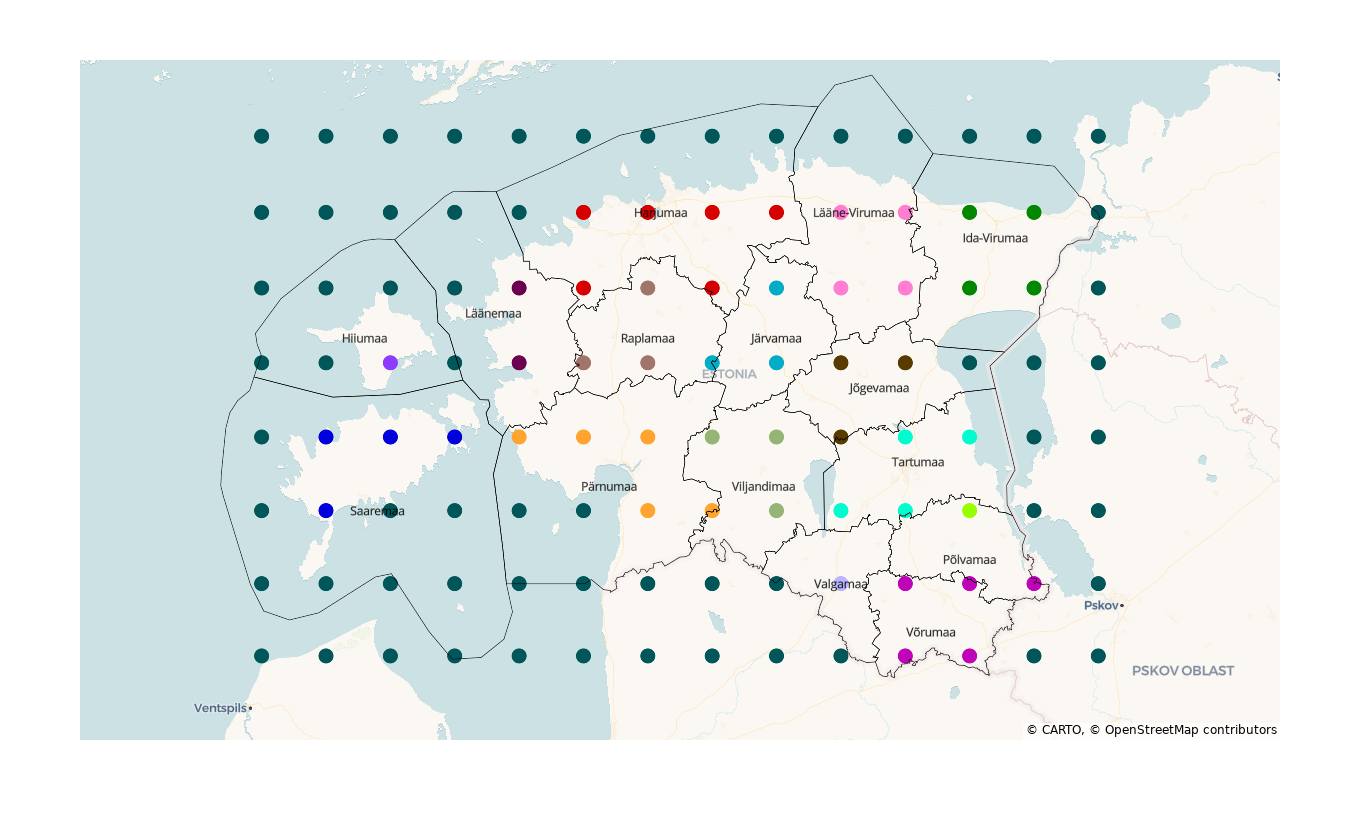

In [ ]:
fig = px.scatter_map(
    lat=station_county_mapping.sort_values("county_index")["latitude"] / 10,
    lon=station_county_mapping.sort_values("county_index")["longitude"] / 10,
    color=station_county_mapping.sort_values("county_index")["county"],
    zoom=6.5,
    width=1360,
    height=820,
    color_discrete_sequence=PALETTE,
)

fig.update_layout(
    showlegend=False,
    map=dict(
        layers=[
            dict(
                sourcetype="geojson",
                source=estonia_geojson,
                type="line",
                color="black",
                line=dict(width=0.5),
            )
        ]
    ),
)

fig.add_trace(
    go.Scattermap(
        lat=centroid_lats,
        lon=centroid_lons,
        mode="text",
        text=region_names,
        textfont=dict(size=12, color="black"),
    )
)
fig.update_traces(marker=dict(size=16))

# fig.show()

fig.write_image("map.png")
Image("map.png")

## DataFrames Merging

For the `unknown` county in the target, both forecast and historical weather data will be aggregated from all counties, but data from `station_county_mapping` with `12` (`NaN`) values for the county (corresponding to geopoints in water or outside Estonia's boundaries) will be excluded. While the option of adding border or water points for the counties can be considered, such combinations will not be used at the moment.

Additionally, an extra flag feature indicating daylight saving time is necessary, as it influences various factors, such as the start of the workday.

In [ ]:
def avg_weather_data(df: pd.DataFrame, mapper: pd.DataFrame) -> pd.DataFrame:
    """
    Compute mean aggregated weather data per county and overall.

    This function creates a deep copy of the input DataFrame, merges it
    with the county mapping, and computes the mean of all numerical
    weather features grouped by time-related columns and county, as
    well as the overall mean across all counties.

    Parameters
    ----------
    df : pd.DataFrame
        Input weather data with latitude, longitude, datetime,
        numerical weather features.
    mapper : pd.DataFrame
        DataFrame that maps each location to a county containing
        "county", "latitude", and "longitude" columns. Only rows with a
        known "county" (i.e., not 'unknown') are used for merging.

    Returns
    -------
    pd.DataFrame
        DataFrame with mean aggregated weather data per county and overall.
    """

    # Merge weather data with county mapping, excluding 'unknown'
    # values which correspond to locations outside of Estonia
    df = df.copy()
    df = pd.merge(
        left=mapper.loc[
            mapper["county"] != "unknown",
            ["county", "latitude", "longitude"],
        ],
        right=df,
        how="left",
        on=["latitude", "longitude"],
        validate="1:m",
    )

    # Identify and exclude grouping columns from average calculation
    groups = [
        c
        for c in df.columns.tolist()
        if "datetime" in c or c == "hours_ahead" or c == "data_block_id"
    ]
    excluded_c = groups + ["county", "latitude", "longitude",]
    avg_c = [c for c in df.columns if c not in excluded_c]
    dtypes = df[avg_c].dtypes.to_dict()
    to_round = [k for k, v in dtypes.items() if np.issubdtype(v, np.integer)]

    # Compute overall mean (county='unknown'), then per-county mean,
    # and concatenate both results
    df = pd.concat(
        [
            df.groupby(groups, as_index=False, observed=True)[avg_c]
            .mean()
            .assign(county="unknown"),
            df.groupby(groups + ["county"], as_index=False, observed=True)[
                avg_c
            ].mean(),
        ],
        ignore_index=True,
    )
    dtypes.update({"county": "category"})

    # Round integer-derived columns back to integers and cast all
    # columns to original dtypes
    df[to_round] = df[to_round].round()
    df = df.astype(dtypes)
    return df[["county"] + groups + avg_c]

In [ ]:
def target_lag(df: pd.DataFrame, lag: int) -> pd.DataFrame:
    """
    Shift 'datetime' by 'lag' days and rename 'target' to
    'h{lag}_target'.
    """
    return (
        df[TARGET_C + ["target"]]
        .copy()
        .assign(datetime=lambda d: d["datetime"] + pd.Timedelta(days=lag))
        .rename(columns={"target": f"h{lag}_target"})
    )

In [ ]:
df = pd.merge(
    left=train_df.drop(columns=["prediction_unit_id", "row_id"]),
    right=client_df.drop(columns=["date"]),
    on=["county", "product_type", "is_business", "data_block_id"],
)

In [ ]:
for lag in [2, 7]:
    df = df.merge(
        target_lag(df, lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df = df.merge(
    right=gas_prices_df.drop(columns=["origin_date", "forecast_date"]),
    on=["data_block_id"],
)

In [ ]:
df = df.merge(
    right=electricity_prices_df.drop(
        columns=["origin_datetime", "forecast_datetime"]
    ),
    left_on=["datetime", "data_block_id"],
    right_on=["electricity_datetime", "data_block_id"],
).drop(columns=["electricity_datetime"])

In [ ]:
fp = "f1_"  # 1 Prefix for columns related to the 1 day forecast
df = df.merge(
    avg_weather_data(forecast_weather_df, station_county_mapping).add_prefix(
        fp
    ),
    how="left",
    left_on=["county", "datetime", "data_block_id"],
    right_on=[
        fp + c for c in ["county", "forecast_datetime", "data_block_id"]
    ],
).drop(
    columns=[
        fp + c
        for c in [
            "county",
            "origin_datetime",
            "hours_ahead",
            "forecast_datetime",
            "data_block_id",
        ]
    ]
)

In [ ]:
# Add 2 days of historical data since 1 day prior data is not fully
# available
hp = "h2_"  # Prefix for columns related to 2 day historical data
hw_df = avg_weather_data(historical_weather_df, station_county_mapping)
hw_df["fully_available_at"] = hw_df["datetime"] + pd.Timedelta("2 d")
df = df.merge(
    hw_df.add_prefix(hp),
    how="left",
    left_on=["county", "datetime"],
    right_on=[hp + c for c in ["county", "fully_available_at"]],
).drop(
    columns=[
        hp + c
        for c in [
            "county",
            "datetime",
            "fully_available_at",
            "data_block_id",
        ]
    ]
)

del hw_df  # Remove temporal groupping df

# Add a flag indicating Daylight Saving Time
df["dst"] = ~(
    ((df.datetime > na_datetimes[0]) & (df.datetime < na_datetimes[1]))
    | ((df.datetime > na_datetimes[2]) & (df.datetime < na_datetimes[3]))
)

In [ ]:
df = df.dropna()

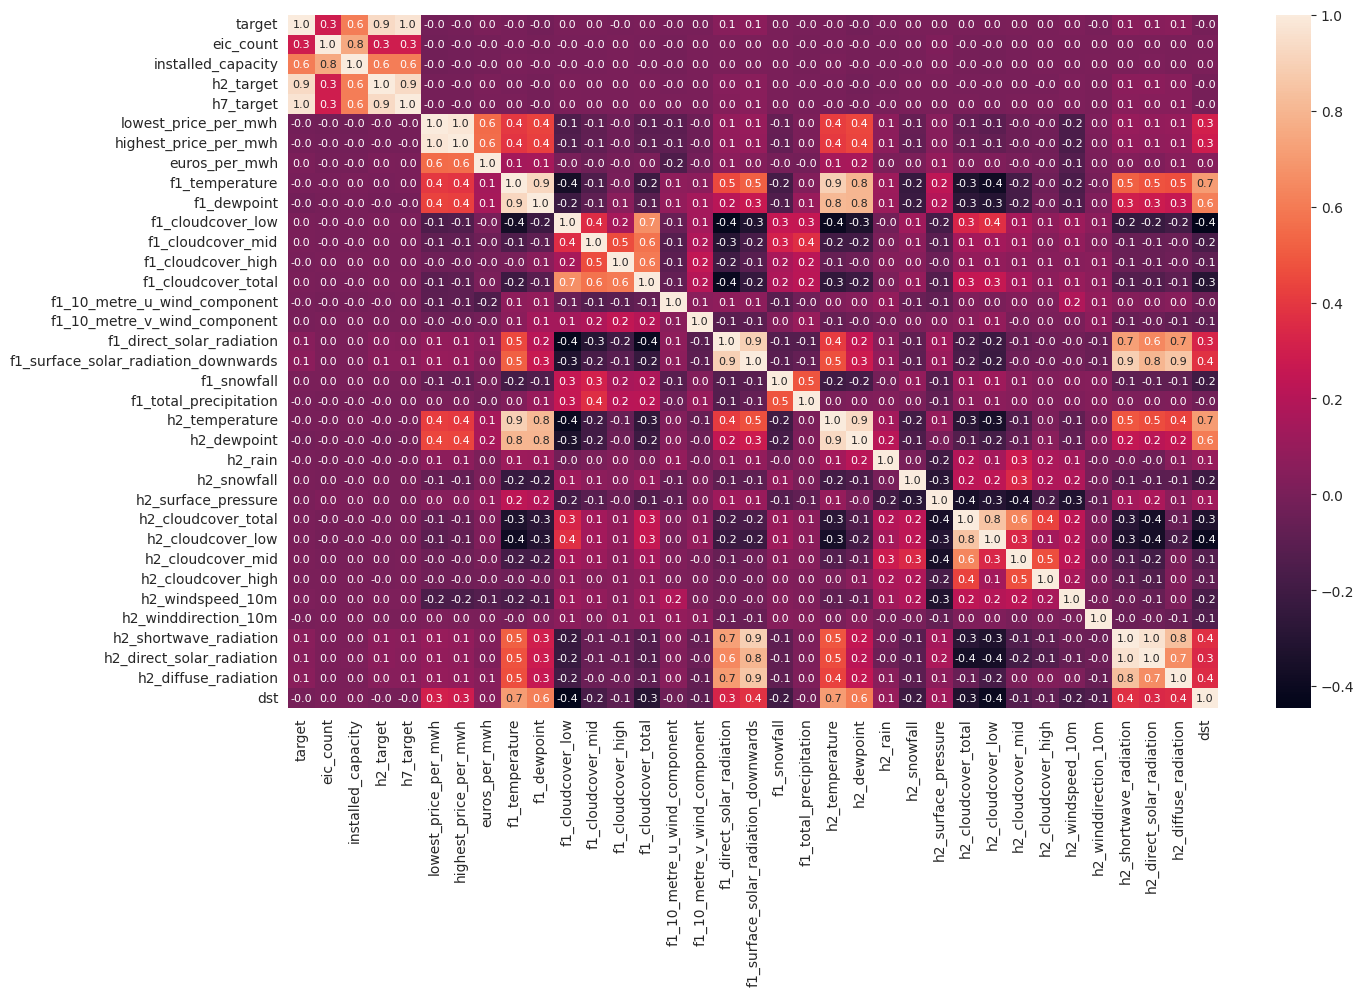

In [ ]:
plt.figure(figsize=(15, 9))
sns.heatmap(
    df.drop(
        columns=[
            "county",
            "product_type",
            "is_business",
            "is_consumption",
            "datetime",
            "data_block_id"
        ]
    ).corr(),
    annot=True,
    fmt=".1f",
    annot_kws={"size": 8}
)
plt.show()

In [ ]:
# Add historical weather data feateurs
# Add sun/radiation/angle feature or combination

## Target

### Distribution

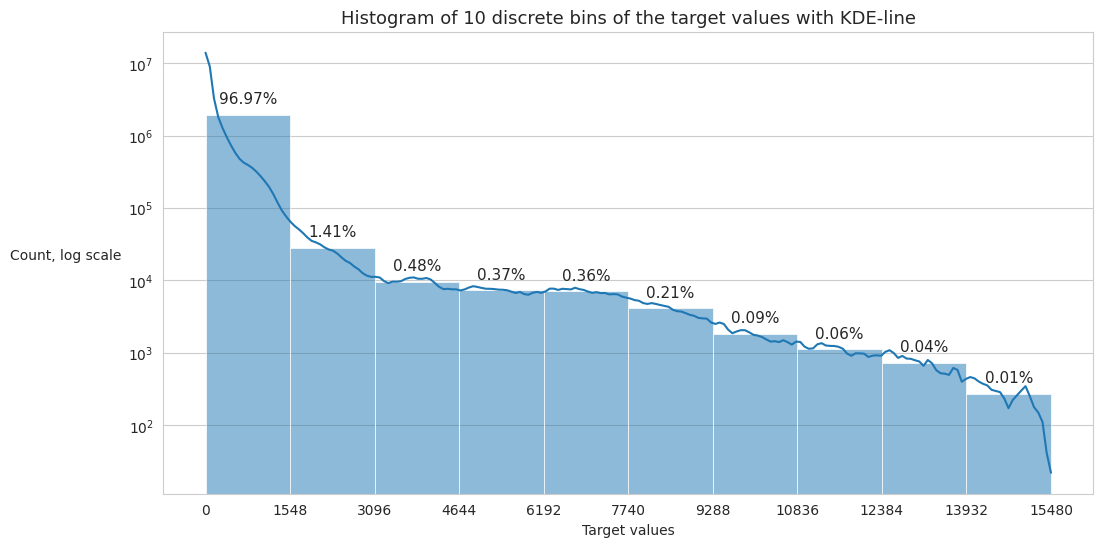

In [ ]:
# Creating target's discrete intervals
bins = 10
plt.figure(figsize=(12, 6))

target_bins_percentage = (
    pd.cut(df.target, bins=bins, precision=0)
    .value_counts()
    .div(len(df))
    .mul(100)
    .round(2)
)

# Due to rounding, the sum of percentages is not exactly 100.0, so
# adjust the first value to ensure the total sum is 100.0
target_bins_percentage[0] += 100 - target_bins_percentage.sum()
target_bins_percentage = [f"{i:.2f}%" for i in target_bins_percentage]

target_max = df.target.max()
ticks = range(0, int(target_max) + 1, int(target_max / bins))

ax = sns.histplot(
    data=df.target,
    bins=bins,
    kde=True,
    linewidth=0.5,
)

# Adding group percentage to the top of each bar
ax.bar_label(ax.containers[0], target_bins_percentage, padding=6, fontsize=11)

plt.xticks(ticks=ticks, rotation=0)

# Using a logarithmic scale for the y-axis for better visualization
# of small quantities of target values
plt.yscale("log")

plt.title(
    f"Histogram of {bins} discrete bins of the target values with KDE-line",
    fontsize=13,
)
plt.xlabel("Target values", fontsize=10)
plt.ylabel("Count, log scale", fontsize=10, rotation=0, labelpad=45)
plt.grid(False, axis="x")
plt.show()

- The target distribution is non-normal and right-skewed, likely because many prosumers are individuals with contracts for their homes, resulting in lower consumption/generation values.
- The first discrete bin contains more values than all the other bins combined, with the KDE line confirming that most values are concentrated below 500 (which corresponds to roughly the left third of the range of the first bin on the x-axis).

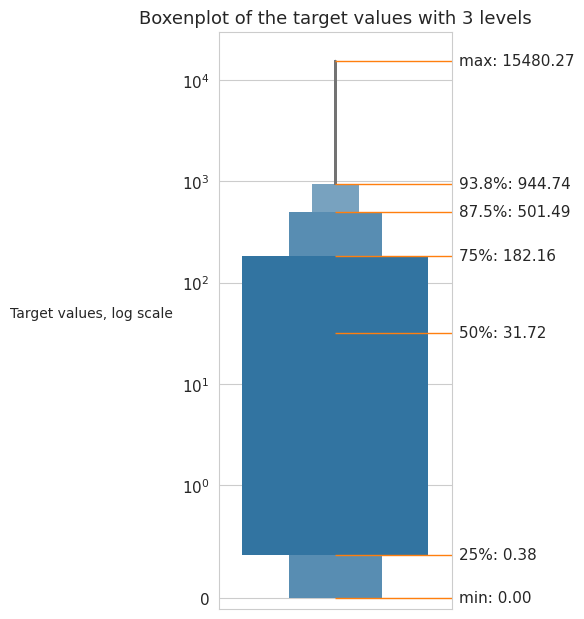

In [ ]:
levels = 3  # The number of boxenplot levels

# List with data for additional lines and text started from .25 because
# lower corresponding percentiles are the same

levels_list = [0.25] + np.cumsum(
    [0.5 / pow(2, i) for i in range(levels + 1)]
).tolist()
levels_values = df.target.describe(levels_list)[3:]

plt.figure(figsize=(3, 7.5))
ax = sns.boxenplot(
    df,
    y="target",
    linewidth=0,
    k_depth=levels,
    flier_kws={
        "marker": ".",
        "s": 0.1,
    },
)

ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

plt.hlines(
    levels_values.values,
    0,
    ax.get_xlim()[1],
    "tab:orange",
    lw=1,
)

for label, value in levels_values.items():
    plt.text(
        ax.get_xlim()[1] + 0.03,
        value,
        f"{label}: {value:.2f}",
        fontsize=11,
        ha="left",
        va="center",
    )

ax.set_ylim(-0.1, 30_000)
plt.yscale("symlog", linthresh=1)
plt.title(f"Boxenplot of the target values with {levels} levels", fontsize=13)
plt.ylabel("Target values, log scale", fontsize=10, rotation=0, labelpad=65)
plt.yticks(fontsize=11)
plt.show()

- Q<sub>1</sub> ≈ 0.38
- Q<sub>2</sub> ≈ 31.26
- Q<sub>3</sub> ≈ 180.63

There are only two levels on the Q<sub>1</sub> side of the boxenplot (as opposed to three levels on the Q<sub>3</sub> side), which means that there is a huge number of identical values that cannot be separated. That is, two different percentiles (6.25% and 12.5%) have the same value, which equal to the minimum value - 0.

In [ ]:
df["target"].value_counts().head()

target
0.00        343657
1.00e-03     10545
3.00e-03      6556
2.00e-03      5271
4.00e-03      4552
Name: count, dtype: int64

Zero values are the most common and occur in more than 15% of the cases.

### Target Over Time

Both classes have equal numbers of entries.

In [ ]:
# Consumption values are multiplied by (-1) for better visualisation
df["modified_target"] = np.where(
    df["is_consumption"] == "consumption",
    df["target"].mul(-1),
    df["target"],
)

In [ ]:
# Adding new time-related features based on datetime

# df["hour"] = df["datetime"].dt.hour.astype("uint8")
# df["day_of_week"] = df["datetime"].dt.day_of_week.astype("uint8")
# df["day"] = df["datetime"].dt.day.astype("uint16")

# df["month"] = df["datetime"].dt.month.astype("int8")
# df["date"] = df["datetime"].dt.date.astype("category")
# df["quarter"] = df["datetime"].dt.quarter.astype("int8")
# df["year"] = df["datetime"].dt.year.astype("uint16")

df["day"] = df["datetime"].dt.day.astype("uint8").astype("category")
df["month"] = df["datetime"].dt.month.astype("uint8").astype("category")
df["year"] = df["datetime"].dt.year.astype("uint16").astype("category")
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

# df["year_week"] = df['datetime'].dt.strftime('%Y-%W').astype("category")
# df["year_month"] = df['datetime'].dt.strftime('%Y-%m').astype("category")

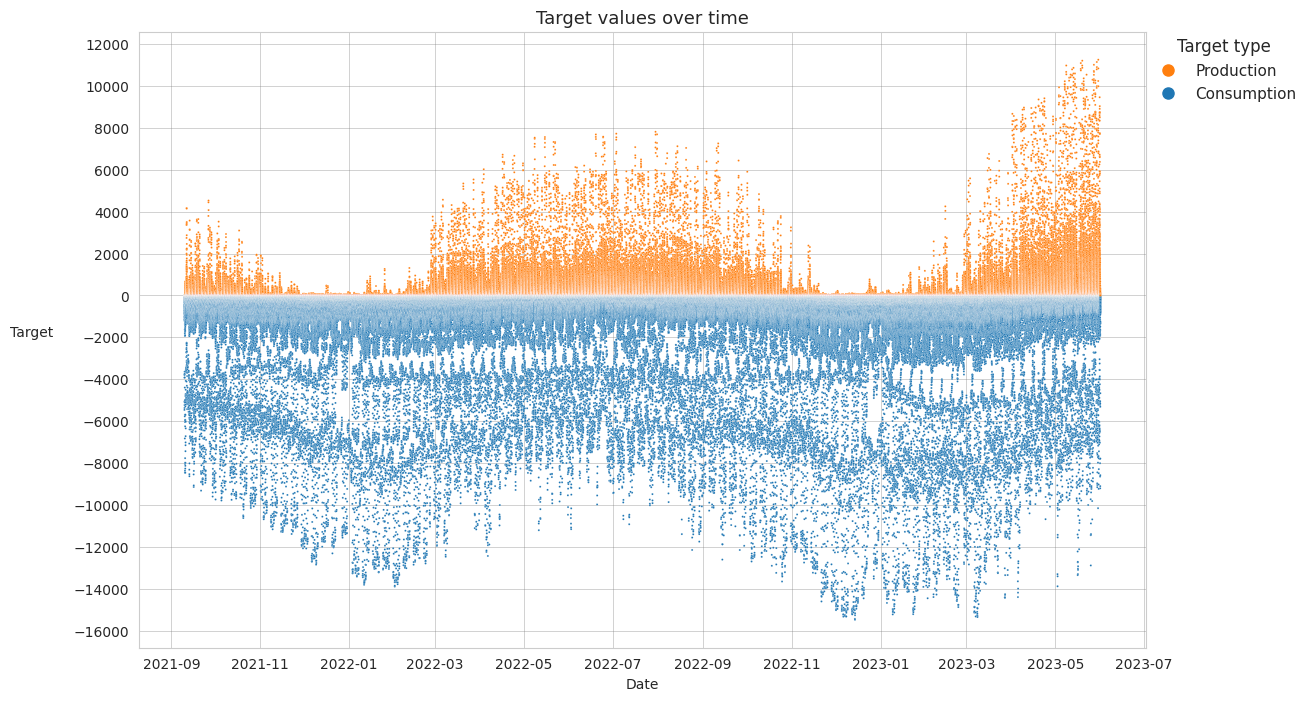

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(
    data=df,
    x="datetime",
    y="modified_target",
    hue="is_consumption",
    s=2,
)

consumption_patch = circle_label("tab:blue", "Consumption",)
production_patch = circle_label("tab:orange", "Production")

plt.legend(
    handles=[production_patch, consumption_patch],
    title="Target type",
    title_fontsize=12,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False,
    fontsize=11,
)

ax.xaxis.set_major_locator(MonthLocator(interval=2))
ax.yaxis.set_major_locator(MultipleLocator(2000))

plt.title("Target values over time", fontsize=13)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Target", fontsize=10, rotation=0, labelpad=30)
plt.grid(color="grey", linewidth=0.5, alpha=0.5)
plt.show()

Notable observations and assumptions:

- Electricity consumption and production values have been increasing year over year.
- The plot shows a wider range of values for consumption, likely because many production values are 0 or near 0. As a result, target consumption values tend to be higher in terms of descriptive statistics.
- Seasonal cycles: Production values approach zero during winter and increase toward midsummer, while consumption behaves oppositely, peaking in winter and decreasing in summer.
- Weekly cycles: Both consumption and production target values exhibit cyclic patterns, likely tied to working days and weekends.
- A decrease in maximum values and the presence of 'voids' for high consumption values are observed around the New Year holidays, which could suggest a pause in business operations during this period (i.e., target values with `is_business` = True).

Given the high point density near 0 and the prevalence of high values, creating a symlog variant of the scatterplot with values grouped by year-week would be beneficial. Furthermore, using color differentiation by `product_type` instead of `is_consumption` would enhance the visualization.

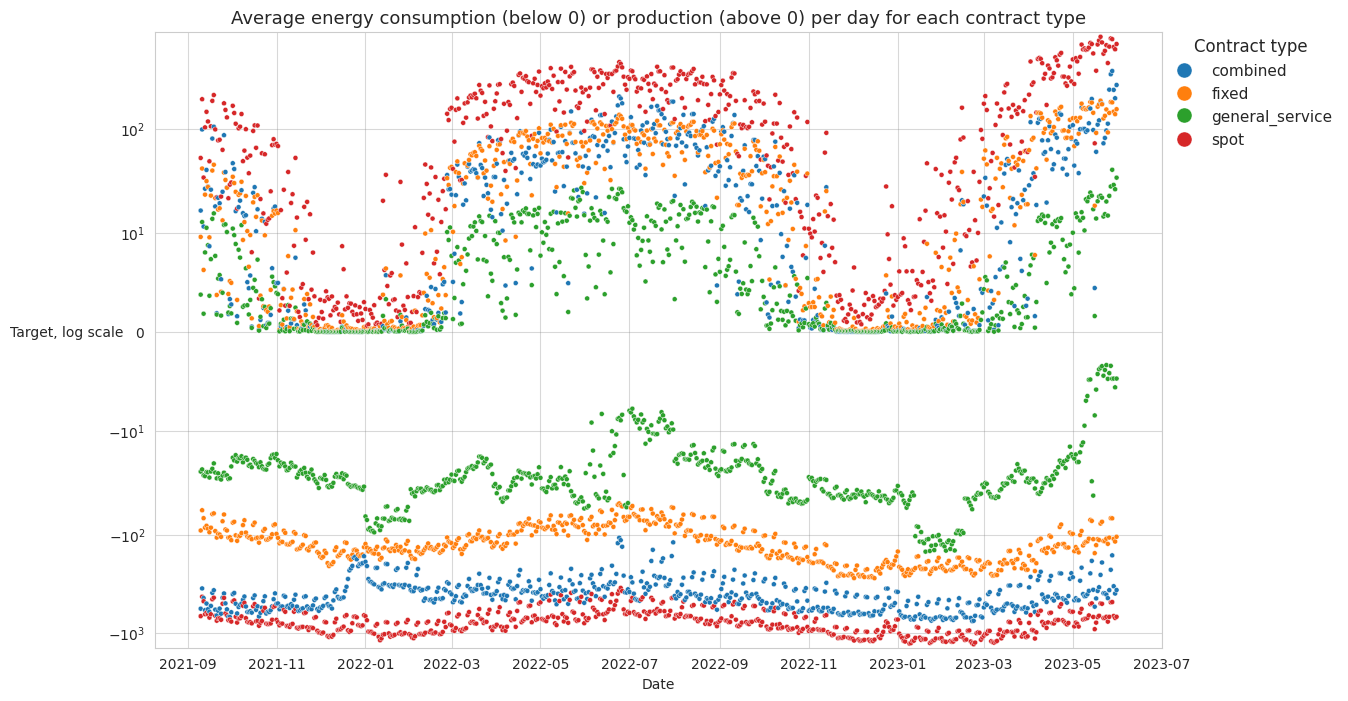

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(
    df.groupby(
        ["year", "month", "day", "is_consumption", "product_type"],
        observed=True,
        as_index=False,
    )["modified_target"]
    .mean()
    .assign(date=lambda d: pd.to_datetime(d[["year", "month", "day"]])),
    x="date",
    y="modified_target",
    hue="product_type",
    s=13,
)

plt.legend(
    title="Contract type",
    title_fontsize=12,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    borderaxespad=0,
    markerscale=3,
    frameon=False,
    fontsize=11,
)

plt.yscale("symlog", linthresh=11)

plt.title(
    "Average energy consumption (below 0) or production (above 0) per "
    "day for each contract type",
    fontsize=13,
)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Target, log scale", fontsize=10, rotation=0, labelpad=30)
plt.grid(alpha=0.3, c="grey")
plt.show()

- Seasonal variations in daily average consumption values are significantly smaller in relative terms (i.e., the percentage change between summer and winter) compared to production. This is likely because energy production by prosumers is severely limited in winter due to low temperatures, shorter daylight hours, and a lower angle of sunlight.
- The lowest daily average consumption values are observed for general_service contracts, followed by fixed, combined, and spot contracts. While there are small overlaps in consumption levels on certain dates, these four series are still visually distinguishable.
- The range of daily average energy production values follows a similar pattern, but with more overlaps: the lowest values are found in general_service, the highest in spot, while fixed and combined contracts fall somewhere in between.

Additionally, it would be useful to analyze production and consumption across different counties.

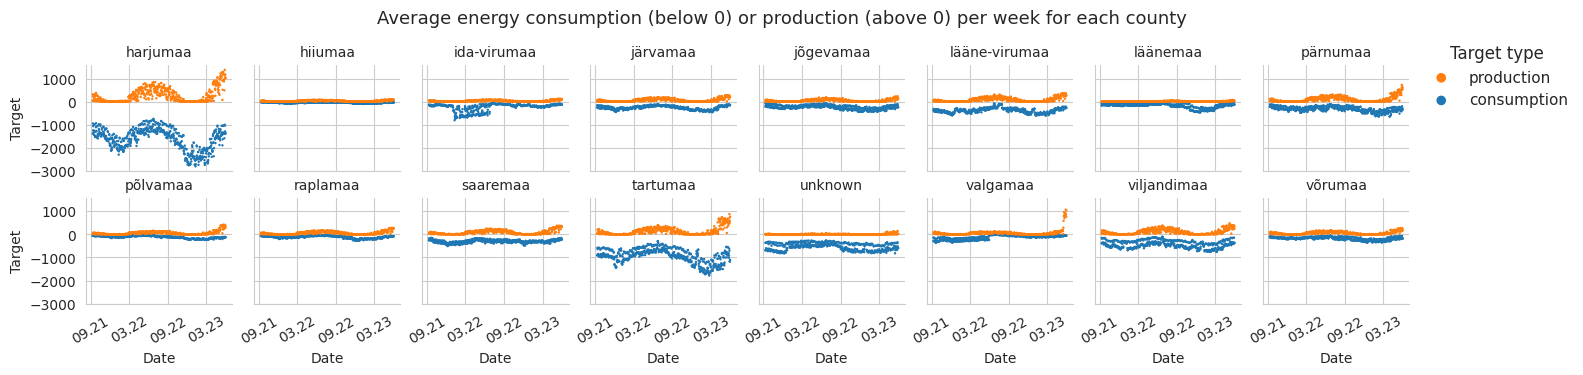

In [ ]:
g = sns.FacetGrid(
    df.groupby(
        ["year", "month", "day", "is_consumption", "county"],
        observed=True,
        as_index=False,
    )["modified_target"]
    .mean()
    .assign(date=lambda d: pd.to_datetime(d[["year", "month", "day"]])),
    col="county",
    hue="is_consumption",
    col_wrap=8,
    height=1.8,
)

g.map_dataframe(
    sns.scatterplot, x="date", y="modified_target", s=3, edgecolor="none"
)

for ax in g.axes.flat:
    ax.xaxis.set_major_locator(MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter("%m.%y"))
    ax.tick_params(axis="x", rotation=30)
    ax.yaxis.set_major_locator(MultipleLocator(1000))

g.set_axis_labels("Date", "Target")
g.set_titles(col_template="{col_name}")
g.add_legend(
    title="Target type",
    label_order=["production", "consumption"],
    markerscale=4,
    bbox_to_anchor=(0.9, 0.9),
    loc="upper left",
    borderaxespad=0,
    frameon=False,
    fontsize=11,
)
g.legend.get_title().set_fontsize(12)
g.figure.suptitle(
    "Average energy consumption (below 0) or production (above 0) per "
    "week for each county",
    fontsize=13,
)
g.figure.subplots_adjust(top=0.825, wspace=0.15, hspace=0.25)
plt.show()

- Harjumaa and Tartumaa have the highest average energy production and consumption levels, likely due to the presence of large-scale energy consumers and producers in these counties. It is also probable that many consumers in these areas have combined or fixed contract types.
- Some counties, such as Hiiumaa, exhibit low and relatively stable energy production and/or consumption levels.
- Certain counties display abrupt changes in the graphs that do not repeat. For example, Valgamaa experiences a sharp increase in electricity production toward the end of the observation period, Ida-Virumaa sees the emergence of new consumption levels during the first half of the period, and unknown county undergoes a sharp decline in consumption levels (which later returns to a previous level), whereas in Valgamaa, the decline does not reverse. These changes are most likely due to fluctuations in the number of installed solar panels and batteries.
- Seasonal patterns are evident in almost all graphs.

[Time Series Gaps](#Time-Series-Gaps)

In [ ]:
t = df.loc[
    (df.county == "harjumaa")
    & (df.product_type == "fixed")
    & (df.is_business == "not_business")
    & (df.is_consumption == "production"),
    ["datetime", "target"],
].copy().set_index('datetime').sort_values('datetime')

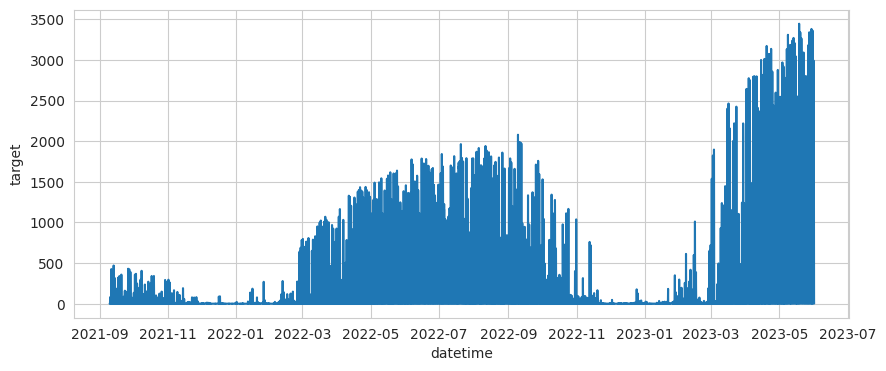

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(t, x="datetime", y="target", markers=True)
plt.show()

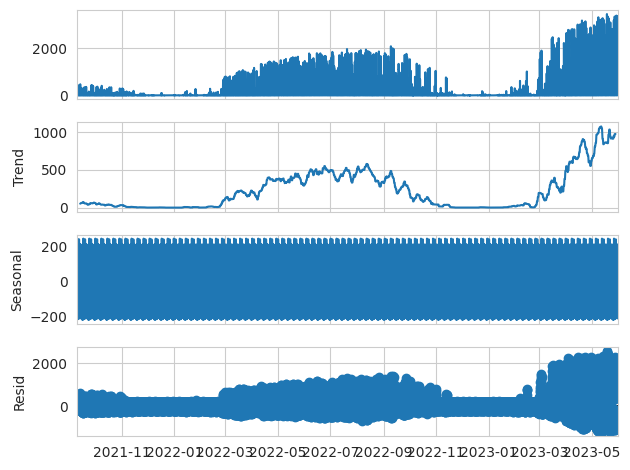

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    t,
    model="additive",
    period=24 * 7,
)
decomposition.plot()
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# plt.figure(figsize=(14, 8))
# plt.subplot(411)
# plt.plot(
#     t,
#     label="Original Time series",
# )
# plt.subplot(412)
# plt.plot(trend, label="Trend")
# plt.subplot(413)
# plt.plot(seasonal, label="Seasonal")
# plt.subplot(414)
# plt.plot(residual, label="Residual")
plt.show()

## Client features

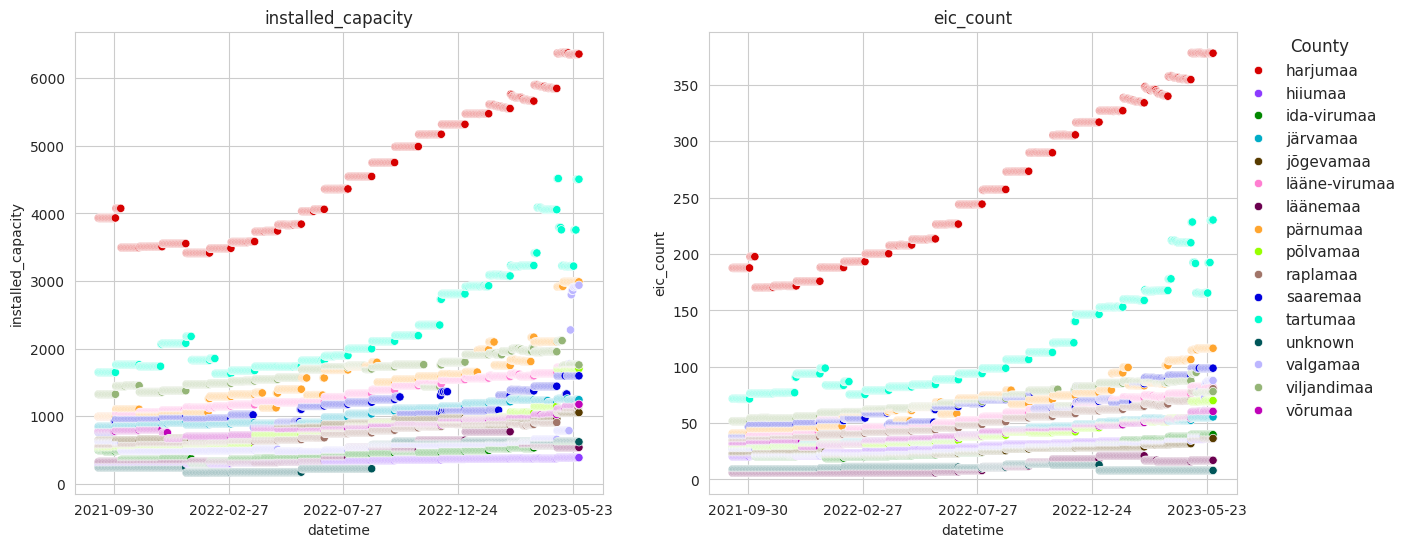

In [ ]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ic_ec_df = (
    df.assign(datetime=df["datetime"].dt.date)
    .groupby(["datetime", "county"], as_index=False, observed=True)[
        ["eic_count", "installed_capacity"]
    ]
    .mean()
)
plt1 = sns.scatterplot(
    data=ic_ec_df,
    x="datetime",
    y="installed_capacity",
    hue="county",
    palette=PALETTE,
    legend=False,
    ax=axes[0],
)
axes[0].set_title("installed_capacity")

plt2 = sns.scatterplot(
    data=ic_ec_df,
    x="datetime",
    y="eic_count",
    hue="county",
    palette=PALETTE,
    ax=axes[1],
)
axes[1].set_title("eic_count")
handles, labels = plt2.get_legend_handles_labels()

plt.legend(
    title="County",
    title_fontsize=12,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False,
    fontsize=11,
)
for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

plt.show()

### Compare different aggregations of weather forecast - historical weather.
### Feature Engineering

In [ ]:
# df_hours = df.copy()

# hours_ago = (
#     [i for i in range(1, 25)]
#     + [24 * i for i in range(2, 8)]
#     + [168 * i for i in range(2, 9)]
#     + [672 * i for i in range(3, 13)]
# )
# for h in hours_ago:
#     df_hours[f"tm_{h}h"] = df_hours["modified_target"].shift(h)
# df_hours.info()

In [ ]:
# df["tm_1h"] = df["modified_target"].shift(1)
# def add_lags(df):
#     target_map = df['PJME_MW'].to_dict()
#     df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
#     df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
#     df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
#     return df
# df_label = pd.get_dummies(df_label, drop_first=True)
# df_label.info()

In [ ]:
# X = df_label.drop(
#     columns=[
#         "target",
#         "data_block_id",
#         "row_id",
#         "prediction_unit_id",
#         "modified_target",
#     ],
#     axis=1,
# )

# y = df_label["modified_target"].values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=RAND
# )

# st = StandardScaler()
# X_train_std = st.fit_transform(X_train)
# X_test_std = st.transform(X_test)

In [ ]:
# def r2_adjusted(
#     y_true: np.ndarray, y_pred: np.ndarray, X_test: np.ndarray | int
# ) -> float:
#     """Коэффициент детерминации (множественная регрессия)"""
#     N_objects = len(y_true)

#     if isinstance(X_test, np.ndarray):
#         N_features = X_test.shape[1]
#     else:
#         N_features = X_test

#     #     N_features = X_test.shape[1]
#     r2 = r2_score(y_true, y_pred)
#     return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


# def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     """Mean percentage error"""
#     return np.mean((y_true - y_pred) / y_true, axis=0) * 100


# def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     """Mean absolute percentage error"""
#     return np.mean(np.abs((y_pred - y_true) / y_true), axis=0) * 100


# def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     """Weighted Absolute Percent Error"""
#     return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


# def huber_loss(
#     y_true: np.ndarray | pd.DataFrame,
#     y_pred: np.ndarray | pd.DataFrame,
#     delta: float = 1.345,
# ):
#     """Функция ошибки Хьюбера"""

#     if isinstance(y_true, pd.DataFrame):
#         y_true = y_true.squeeze().to_numpy()
#     if isinstance(y_pred, pd.DataFrame):
#         y_pred = y_pred.squeeze().to_numpy()

#     assert len(y_true) == len(y_pred), "Разные размеры данных"
#     huber_sum = 0
#     for i in range(len(y_true)):
#         if abs(y_true[i] - y_pred[i]) <= delta:
#             huber_sum += 0.5 * (y_true[i] - y_pred[i]) ** 2
#         else:
#             huber_sum += delta * (abs(y_true[i] - y_pred[i]) - 0.5 * delta)
#     huber_sum /= len(y_true)
#     return huber_sum


# def logcosh(y_true: np.ndarray, y_pred: np.ndarray):
#     """функция ошибки Лог-Кош"""
#     return np.sum(np.log(np.cosh(y_true - y_pred)))


# def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
#     """
#     Root Mean Squared Log Error (RMSLE) metric
#     Логарифмическая ошибка средней квадратичной ошибки
#     """
#     try:
#         return np.sqrt(mean_squared_log_error(y_true, y_pred))
#     except:
#         return None


# def get_metrics(
#     y_test: np.ndarray,
#     y_pred: np.ndarray,
#     X_test: np.ndarray,
#     name: str = None,
#     delta: float = 1.345,
# ):
#     """Генерация таблицы с метриками"""
#     df_metrics = pd.DataFrame()
#     df_metrics["model"] = [name]

#     df_metrics["MAE"] = mean_absolute_error(y_test, y_pred)
#     df_metrics["MSE"] = mean_squared_error(y_test, y_pred)
#     df_metrics["Huber_loss"] = huber_loss(y_test, y_pred, delta)
#     df_metrics["Logcosh"] = logcosh(y_test, y_pred)
#     df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
#     df_metrics["RMSLE"] = rmsle(y_test, y_pred)
#     df_metrics["R2 adjusted"] = r2_adjusted(y_test, y_pred, X_test)
#     df_metrics["MPE_%"] = mpe(y_test, y_pred)
#     df_metrics["MAPE_%"] = mape(y_test, y_pred)
#     df_metrics["WAPE_%"] = wape(y_test, y_pred)

#     return df_metrics

In [ ]:
# df = df.sort_index().sort_values(
#     ["county", "is_business", "product_type", "is_consumption"],
#     kind="mergesort",
# )
# df.sort_index()
# tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

# a = {}
# for i in range(1000):
#     x = 0
#     for j in range(20):
#         x += np.random.choice([-1, 1])
#     a[x] = a.get(x, 0) + 1


# sns.barplot(x=list(a.keys()), y=list(a.values()));

In [ ]:
# min(data.keys())
# max(data.keys())
# len(data.keys())
# {k: 0 for (k, 0) in range(min(data.keys()), max(data.keys())) if not in data.keys()}
# {k: v*2 for (k,v) in dict1.items()}
# {key:value for (key,value) in dictonary.items()}
# zip()

# for train_idx, val_idx in tss.split(df):
# print('1 train:', train_idx)
# display(df.iloc[train_idx].tail(5))
# print('1 val:', val_idx)

In [ ]:
# tss = TimeSeriesSplit(n_splits=3, test_size=300_000)
# df = df.sort_index()

# fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
# fold = 0

# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]
#     train["modified_target"].plot(
#         ax=axs[fold],
#         label="Training Set",
#         title=f"Data Train/Test Split Fold {fold}",
#     )
#     test["modified_target"].plot(ax=axs[fold], label="Test Set")
#     axs[fold].axvline(test.index.min(), color="black", ls="--")
#     fold += 1
# plt.show()

In [ ]:
# fold = 0
# preds = []
# scores = []
# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     reg = XGBRegressor(
#         n_estimators=2000,
#         early_stopping_rounds=50,
#         objective="reg:squarederror",
#         enable_categorical=True,
#         eval_metric="mae",
#         # max_depth=3,
#         learning_rate=0.01,
#         random_state=RAND,
#     )
#     FEATURES = [
#         "county",
#         "is_business",
#         "product_type",
#         # 'target',
#         "is_consumption",
#         # 'data_block_id',
#         # 'row_id',
#         # 'prediction_unit_id',
#         "hour",
#         "day_of_week",
#         "day",
#         "week_of_year",
#         "month",
#         "quarter",
#         "year",
#         # 'modified_target',
#     ]
#     TARGET = "modified_target"

#     X_train = train[FEATURES]
#     y_train = train[TARGET]

#     X_test = test[FEATURES]
#     y_test = test[TARGET]

#     reg.fit(
#         X_train,
#         y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         verbose=20,
#     )

#     y_pred = reg.predict(X_test)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)